# Sistema de Stress Testing - Análisis de Riesgo de Cartera Multi-Activo

## Sección 1: Descarga, Preparación y Análisis Exploratorio de Datos

### Objetivo

Esta sección tiene como objetivo establecer la base de datos histórica para el sistema de stress testing mediante:

1. **Descarga de datos históricos** de una cartera diversificada de ETFs representativos de diferentes clases de activos
2. **Preparación y limpieza** de los datos para garantizar calidad y consistencia
3. **Análisis exploratorio completo** que permita comprender las características estadísticas y dinámicas de los retornos de cada activo y sus relaciones

Los resultados de este análisis serán fundamentales para:
- Identificar períodos de estrés histórico
- Comprender las correlaciones entre activos en diferentes regímenes de mercado
- Validar supuestos sobre distribuciones de retornos
- Establecer métricas base para comparación en escenarios de stress

### Cartera de Análisis

La cartera seleccionada incluye 8 ETFs que representan las principales clases de activos:

- **SPY**: S&P 500 (acciones grandes de EE.UU.)
- **IWM**: Russell 2000 (acciones pequeñas de EE.UU.)
- **EFA**: MSCI EAFE (acciones desarrolladas ex-EE.UU.)
- **EEM**: MSCI Emerging Markets (acciones mercados emergentes)
- **TLT**: Treasury Bonds 20+ años (bonos gubernamentales largos)
- **IEF**: Treasury Bonds 7-10 años (bonos gubernamentales intermedios)
- **HYG**: High Yield Corporate Bonds (bonos corporativos de alto rendimiento)
- **GLD**: Gold (oro físico)

Esta diversificación permite analizar riesgos tanto de acciones como de renta fija, así como diferentes geografías y niveles de riesgo crediticio.

In [1]:
# Importación de librerías necesarias
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configuración de estilo para visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Configuración de pandas para mostrar más columnas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Librerías importadas correctamente")
print(f"Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Librerías importadas correctamente
Fecha de ejecución: 2026-02-01 16:27:48


## 1. Definición de Parámetros y Configuración

Definimos los tickers de los ETFs a analizar y los parámetros para la descarga de datos históricos.

In [2]:
# Definición de tickers de la cartera
tickers = ['SPY', 'IWM', 'EFA', 'EEM', 'TLT', 'IEF', 'HYG', 'GLD']

# Parámetros de descarga
start_date = '2000-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

# Frecuencia de datos: diaria
interval = '1d'

print(f"Tickers a descargar: {', '.join(tickers)}")
print(f"Período: {start_date} a {end_date}")
print(f"Frecuencia: {interval}")

Tickers a descargar: SPY, IWM, EFA, EEM, TLT, IEF, HYG, GLD
Período: 2000-01-01 a 2026-02-01
Frecuencia: 1d


## 2. Descarga de Datos Históricos

Utilizamos `yfinance` para descargar los precios de cierre ajustados de todos los ETFs. Los precios ajustados son fundamentales ya que incorporan dividendos y splits, proporcionando una serie más precisa para el cálculo de retornos.

In [5]:
# Descarga de precios ajustados
print("Iniciando descarga de datos históricos...")
print("-" * 60)

prices_dict = {}

for ticker in tickers:
    try:
        print(f"Descargando {ticker}...", end=' ')
        # auto_adjust=True (default) devuelve 'Close' ya ajustado por dividendos y splits
        data = yf.download(ticker, start=start_date, end=end_date, interval=interval, 
                          auto_adjust=True, progress=False)
        
        if not data.empty:
            # Extraer la columna 'Close' - yfinance puede devolver diferentes estructuras
            close_data = data['Close']
            
            # Si es un DataFrame (MultiIndex), convertir a Serie
            if isinstance(close_data, pd.DataFrame):
                # Tomar la primera columna si hay múltiples
                close_series = close_data.iloc[:, 0] if close_data.shape[1] > 0 else close_data.squeeze()
            elif isinstance(close_data, pd.Series):
                close_series = close_data
            else:
                # Si es escalar u otro tipo, intentar squeeze
                close_series = pd.Series(close_data).squeeze()
            
            # Verificar que tenemos una Serie válida
            if isinstance(close_series, pd.Series) and len(close_series) > 0:
                prices_dict[ticker] = close_series
                print(f"✓ {len(prices_dict[ticker])} observaciones")
            else:
                print(f"✗ Error: No se pudo extraer serie de precios válida")
        else:
            print(f"✗ Sin datos disponibles")
    except Exception as e:
        print(f"✗ Error: {str(e)}")

print("-" * 60)
print(f"Descarga completada. {len(prices_dict)} activos descargados exitosamente.")

# Crear DataFrame con precios
# pd.DataFrame puede manejar un diccionario de Series, pero si hay problemas, usar pd.concat
if prices_dict:
    try:
        prices = pd.DataFrame(prices_dict)
        print(f"\nDimensiones del DataFrame de precios: {prices.shape}")
        if not prices.empty:
            print(f"Rango de fechas: {prices.index[0].strftime('%Y-%m-%d')} a {prices.index[-1].strftime('%Y-%m-%d')}")
        else:
            print("⚠ Advertencia: DataFrame vacío después de la descarga.")
    except ValueError:
        # Si falla, usar pd.concat como alternativa
        prices = pd.concat(prices_dict, axis=1)
        prices.columns = list(prices_dict.keys())
        print(f"\nDimensiones del DataFrame de precios: {prices.shape}")
        if not prices.empty:
            print(f"Rango de fechas: {prices.index[0].strftime('%Y-%m-%d')} a {prices.index[-1].strftime('%Y-%m-%d')}")
else:
    prices = pd.DataFrame()
    print("⚠ Advertencia: No se descargaron datos. Verifique la conexión a internet y los tickers.")

Iniciando descarga de datos históricos...
------------------------------------------------------------
Descargando SPY... ✓ 6559 observaciones
Descargando IWM... ✓ 6458 observaciones
Descargando EFA... ✓ 6143 observaciones
Descargando EEM... ✓ 5737 observaciones
Descargando TLT... ✓ 5915 observaciones
Descargando IEF... ✓ 5915 observaciones
Descargando HYG... ✓ 4733 observaciones
Descargando GLD... ✓ 5333 observaciones
------------------------------------------------------------
Descarga completada. 8 activos descargados exitosamente.

Dimensiones del DataFrame de precios: (6559, 8)
Rango de fechas: 2000-01-03 a 2026-01-30


## 3. Cálculo de Retornos Logarítmicos

### Justificación de Retornos Logarítmicos

Los retornos logarítmicos (o retornos continuamente compuestos) son preferibles a los retornos simples por varias razones:

1. **Aditividad temporal**: Los retornos logarítmicos son aditivos en el tiempo, lo que facilita el cálculo de retornos multiperíodo
2. **Simetría**: La distribución de retornos logarítmicos es más simétrica que la de retornos simples
3. **Propiedades estadísticas**: Facilitan el modelado estadístico y son consistentes con modelos de procesos estocásticos (como el movimiento browniano geométrico)
4. **Aproximación**: Para retornos pequeños, los retornos logarítmicos y simples son aproximadamente iguales, pero los logarítmicos son más precisos para períodos largos

La fórmula utilizada es: $r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) = \ln(P_t) - \ln(P_{t-1})$

In [6]:
# Cálculo de retornos logarítmicos diarios
# r_t = ln(P_t / P_{t-1}) = ln(P_t) - ln(P_{t-1})
returns = np.log(prices / prices.shift(1))

# Eliminar la primera fila que contiene NaN (no hay precio anterior)
returns = returns.iloc[1:]

print("Retornos logarítmicos calculados")
print(f"Dimensiones: {returns.shape}")
print(f"\nPrimeras observaciones:")
print(returns.head())
print(f"\nÚltimas observaciones:")
print(returns.tail())

Retornos logarítmicos calculados
Dimensiones: (6558, 8)

Primeras observaciones:
                 SPY  IWM  EFA  EEM  TLT  IEF  HYG  GLD
Date                                                   
2000-01-04 -0.039890  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2000-01-05  0.001786  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2000-01-06 -0.016201  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2000-01-07  0.056452  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2000-01-10  0.003425  NaN  NaN  NaN  NaN  NaN  NaN  NaN

Últimas observaciones:
                 SPY       IWM       EFA       EEM       TLT       IEF  \
Date                                                                     
2026-01-26  0.005065 -0.003139  0.004989  0.001691  0.004765  0.001458   
2026-01-27  0.003976  0.002837  0.015996  0.019581 -0.006245 -0.001145   
2026-01-28 -0.000101 -0.005416 -0.010635  0.006772 -0.002281 -0.000834   
2026-01-29 -0.001986  0.000266  0.006709 -0.005116  0.000228  0.001042   
2026-01-30 -0.002987 -0.014225 -0.009386 -0.022420 -0.00560

## 4. Limpieza y Validación de Datos

Procedemos a limpiar los datos aplicando:
1. **Forward-fill**: Rellenar valores faltantes con el último valor válido (útil para días no hábiles o datos faltantes ocasionales)
2. **Eliminación de NaN restantes**: Eliminar cualquier fila que aún contenga valores faltantes después del forward-fill
3. **Validación de consistencia**: Verificar que todos los activos tengan la misma longitud temporal

In [7]:
# Verificar valores faltantes antes de la limpieza
print("Valores faltantes antes de la limpieza:")
print(returns.isnull().sum())
print(f"\nTotal de filas con al menos un NaN: {returns.isnull().any(axis=1).sum()}")

# Paso 1: Forward-fill (usar ffill() para compatibilidad con versiones recientes de pandas)
returns_cleaned = returns.ffill()

# Paso 2: Eliminar filas con NaN restantes (si las hay)
returns_cleaned = returns_cleaned.dropna()

# Actualizar el DataFrame returns
returns = returns_cleaned.copy()

print("\n" + "="*60)
print("Después de la limpieza:")
print("="*60)
print(f"Valores faltantes: {returns.isnull().sum().sum()}")
print(f"Dimensiones finales: {returns.shape}")
print(f"Rango de fechas: {returns.index[0].strftime('%Y-%m-%d')} a {returns.index[-1].strftime('%Y-%m-%d')}")
print(f"Número total de observaciones: {len(returns)}")

# Validación: verificar que todos los activos tengan la misma longitud
lengths = returns.count()
if lengths.nunique() == 1:
    print(f"\n✓ Validación exitosa: Todos los activos tienen {lengths.iloc[0]} observaciones")
else:
    print(f"\n⚠ Advertencia: Los activos tienen diferentes longitudes")
    print(lengths)

Valores faltantes antes de la limpieza:
SPY       0
IWM     101
EFA     416
EEM     822
TLT     644
IEF     644
HYG    1826
GLD    1226
dtype: int64

Total de filas con al menos un NaN: 1826

Después de la limpieza:
Valores faltantes: 0
Dimensiones finales: (4732, 8)
Rango de fechas: 2007-04-12 a 2026-01-30
Número total de observaciones: 4732

✓ Validación exitosa: Todos los activos tienen 4732 observaciones


## 5. Análisis Exploratorio de Datos

### 5.1. Estadísticas Descriptivas

Calculamos las estadísticas descriptivas fundamentales para cada activo:
- **Media**: Retorno esperado diario
- **Desviación estándar**: Volatilidad diaria (riesgo)
- **Asimetría (Skewness)**: Medida de asimetría de la distribución
- **Curtosis (Kurtosis)**: Medida de colas pesadas (exceso de curtosis respecto a la normal)
- **Mínimo y Máximo**: Retornos extremos observados

In [8]:
# Cálculo de estadísticas descriptivas
stats = pd.DataFrame({
    'Media (diaria)': returns.mean(),
    'Desv. Est. (diaria)': returns.std(),
    'Asimetría': returns.skew(),
    'Curtosis': returns.kurtosis(),
    'Mínimo': returns.min(),
    'Máximo': returns.max(),
    'Mediana': returns.median()
})

# Convertir a anual (asumiendo 252 días hábiles)
stats['Media (anualizada)'] = stats['Media (diaria)'] * 252
stats['Volatilidad (anualizada)'] = stats['Desv. Est. (diaria)'] * np.sqrt(252)

# Reordenar columnas
stats = stats[['Media (diaria)', 'Media (anualizada)', 
               'Desv. Est. (diaria)', 'Volatilidad (anualizada)',
               'Asimetría', 'Curtosis', 'Mínimo', 'Máximo', 'Mediana']]

print("Estadísticas Descriptivas de Retornos")
print("="*80)
print(stats.round(6))

Estadísticas Descriptivas de Retornos
     Media (diaria)  Media (anualizada)  Desv. Est. (diaria)  \
SPY        0.000405            0.102137             0.012490   
IWM        0.000302            0.076009             0.015709   
EFA        0.000174            0.043849             0.013734   
EEM        0.000166            0.041787             0.017568   
TLT        0.000121            0.030489             0.009604   
IEF        0.000131            0.032936             0.004409   
HYG        0.000193            0.048720             0.006907   
GLD        0.000400            0.100761             0.011172   

     Volatilidad (anualizada)  Asimetría   Curtosis    Mínimo    Máximo  \
SPY                  0.198275  -0.295584  13.861034 -0.115886  0.135578   
IWM                  0.249372  -0.517095   6.766232 -0.142335  0.087545   
EFA                  0.218020  -0.354210  13.338003 -0.118369  0.147451   
EEM                  0.278880   0.071784  16.894256 -0.176334  0.205142   
TLT       

### Interpretación de Estadísticas Descriptivas

**Retornos esperados (Media anualizada)**: Indican el rendimiento promedio esperado de cada activo. Las acciones (SPY, IWM, EFA, EEM) típicamente muestran mayores retornos esperados que los bonos, reflejando la prima de riesgo de mercado.

**Volatilidad (Desviación estándar anualizada)**: Mide el riesgo de cada activo. Valores más altos indican mayor incertidumbre en los retornos. Las acciones generalmente muestran mayor volatilidad que los bonos gubernamentales.

**Asimetría**: 
- Valores negativos indican cola izquierda más pesada (mayor probabilidad de pérdidas extremas)
- Valores positivos indican cola derecha más pesada (mayor probabilidad de ganancias extremas)
- Valores cercanos a 0 indican simetría

**Curtosis**: 
- Valores positivos indican colas más pesadas que la distribución normal (mayor probabilidad de eventos extremos)
- Valores negativos indican colas más ligeras
- Una distribución normal tiene curtosis de 0 (exceso de curtosis)

**Mínimo y Máximo**: Proporcionan información sobre los retornos extremos observados históricamente, útiles para identificar períodos de estrés.

### 5.2. Matriz de Correlación

La matriz de correlación mide la relación lineal entre los retornos de diferentes activos. Valores cercanos a 1 indican alta correlación positiva, valores cercanos a -1 indican alta correlación negativa, y valores cercanos a 0 indican baja correlación.

In [9]:
# Cálculo de matriz de correlación
correlation_matrix = returns.corr()

print("Matriz de Correlación de Retornos")
print("="*80)
print(correlation_matrix.round(4))

Matriz de Correlación de Retornos
        SPY     IWM     EFA     EEM     TLT     IEF     HYG     GLD
SPY  1.0000  0.8964  0.8873  0.8269 -0.3158 -0.3065  0.6828  0.0487
IWM  0.8964  1.0000  0.8153  0.7618 -0.2983 -0.2897  0.6243  0.0464
EFA  0.8873  0.8153  1.0000  0.8776 -0.2989 -0.2773  0.6620  0.1465
EEM  0.8269  0.7618  0.8776  1.0000 -0.2818 -0.2842  0.6067  0.1643
TLT -0.3158 -0.2983 -0.2989 -0.2818  1.0000  0.9109 -0.1361  0.1703
IEF -0.3065 -0.2897 -0.2773 -0.2842  0.9109  1.0000 -0.0978  0.2199
HYG  0.6828  0.6243  0.6620  0.6067 -0.1361 -0.0978  1.0000  0.0435
GLD  0.0487  0.0464  0.1465  0.1643  0.1703  0.2199  0.0435  1.0000


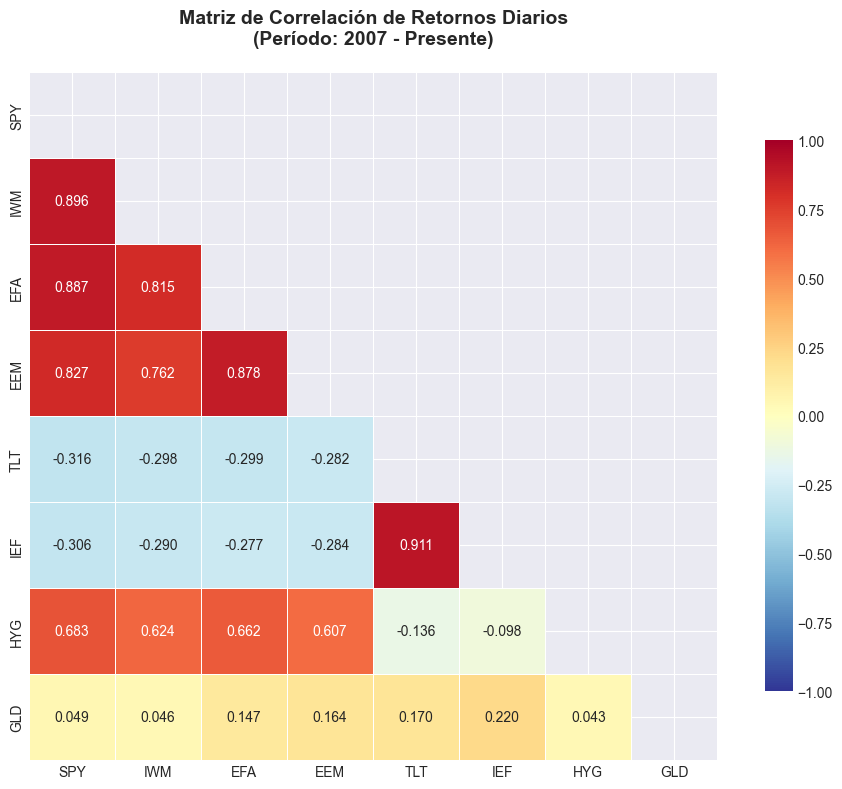

In [11]:
# Visualización: Heatmap de correlación
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Máscara para mostrar solo triángulo inferior
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='RdYlBu_r', 
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8}, mask=mask)
plt.title('Matriz de Correlación de Retornos Diarios\n(Período: 2007 - Presente)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

### Patrones de Correlación Observados

**Correlaciones intra-clase de activos**:
- **Acciones**: SPY, IWM, EFA y EEM típicamente muestran correlaciones positivas altas entre sí, especialmente entre SPY e IWM (ambos de EE.UU.)
- **Bonos gubernamentales**: TLT e IEF muestran alta correlación positiva (ambos son bonos del Tesoro de EE.UU.)
- **Bonos de alto rendimiento**: HYG puede mostrar correlación positiva con acciones debido a su componente de riesgo crediticio

**Correlaciones inter-clase**:
- **Acciones vs. Bonos gubernamentales**: Típicamente correlación negativa o baja, especialmente en períodos de estrés (efecto "flight to quality")
- **Oro (GLD)**: Puede mostrar correlación negativa con acciones y bonos en períodos de incertidumbre, actuando como activo refugio

Estos patrones de correlación son fundamentales para el stress testing, ya que las correlaciones pueden cambiar significativamente durante períodos de estrés del mercado.

### 5.3. Serie Temporal de Retornos Acumulados (Wealth Index)

El wealth index muestra la evolución de una inversión inicial de 100 unidades monetarias en cada activo, permitiendo comparar el rendimiento acumulado a lo largo del tiempo.

In [12]:
# Cálculo del wealth index (base 100)
# Wealth Index = 100 * exp(sum(retornos logarítmicos))
wealth_index = 100 * np.exp(returns.cumsum())

print("Wealth Index calculado (base 100)")
print(f"Valor inicial: 100 para todos los activos")
print(f"\nValores finales:")
final_values = wealth_index.iloc[-1]
for ticker in tickers:
    print(f"{ticker}: {final_values[ticker]:.2f}")

print(f"\nRetorno total acumulado:")
total_returns = (final_values / 100 - 1) * 100
for ticker in tickers:
    print(f"{ticker}: {total_returns[ticker]:.2f}%")

Wealth Index calculado (base 100)
Valor inicial: 100 para todos los activos

Valores finales:
SPY: 680.67
IWM: 416.74
EFA: 227.82
EEM: 219.17
TLT: 177.27
IEF: 185.61
HYG: 249.64
GLD: 663.31

Retorno total acumulado:
SPY: 580.67%
IWM: 316.74%
EFA: 127.82%
EEM: 119.17%
TLT: 77.27%
IEF: 85.61%
HYG: 149.64%
GLD: 563.31%


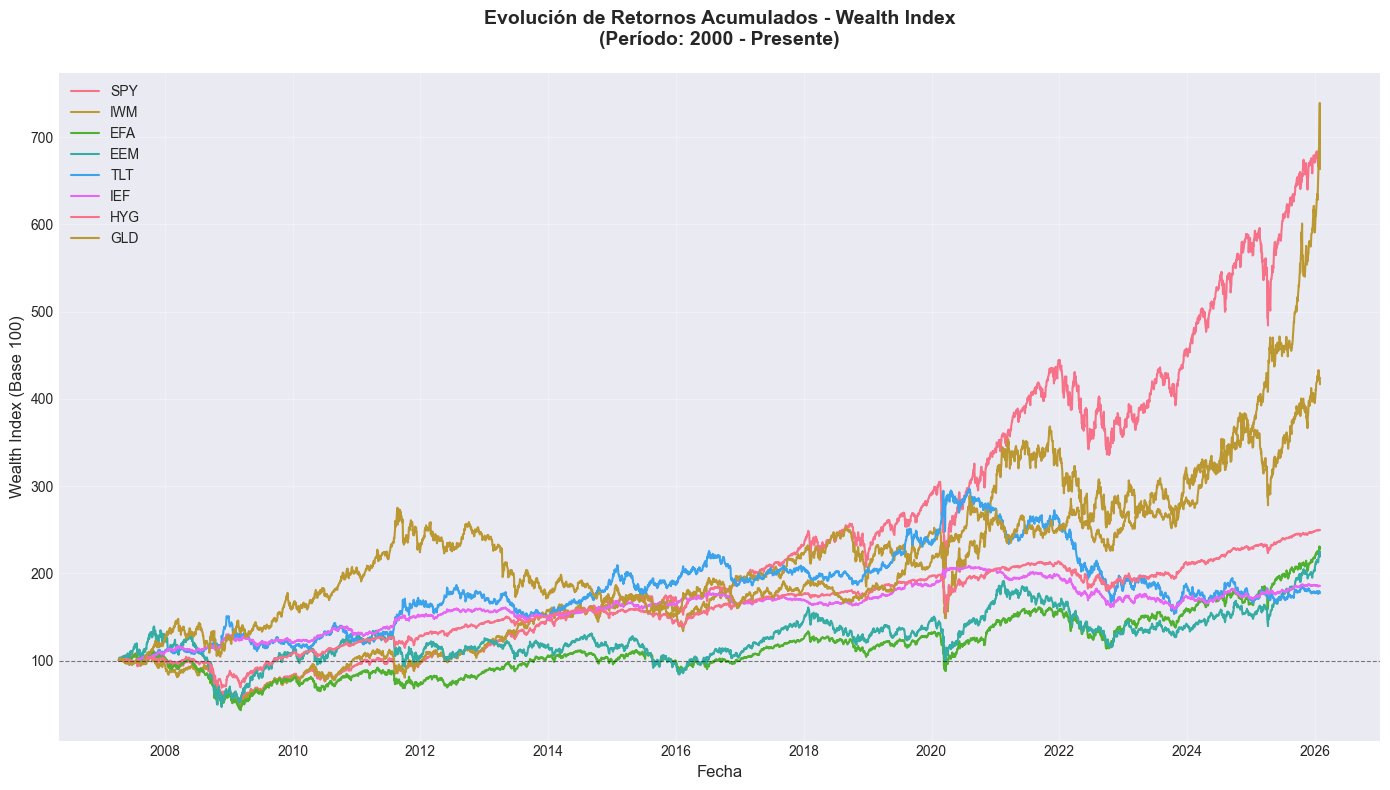

In [13]:
# Visualización: Wealth Index para todos los activos
plt.figure(figsize=(14, 8))
for ticker in tickers:
    plt.plot(wealth_index.index, wealth_index[ticker], label=ticker, linewidth=1.5)

plt.axhline(y=100, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Wealth Index (Base 100)', fontsize=12)
plt.title('Evolución de Retornos Acumulados - Wealth Index\n(Período: 2000 - Presente)', 
          fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.4. Distribución Empírica de Retornos

Analizamos la distribución empírica de retornos para cada activo mediante histogramas, comparándola con una distribución normal teórica con la misma media y desviación estándar. Esto permite identificar desviaciones de la normalidad, como asimetría y colas pesadas.

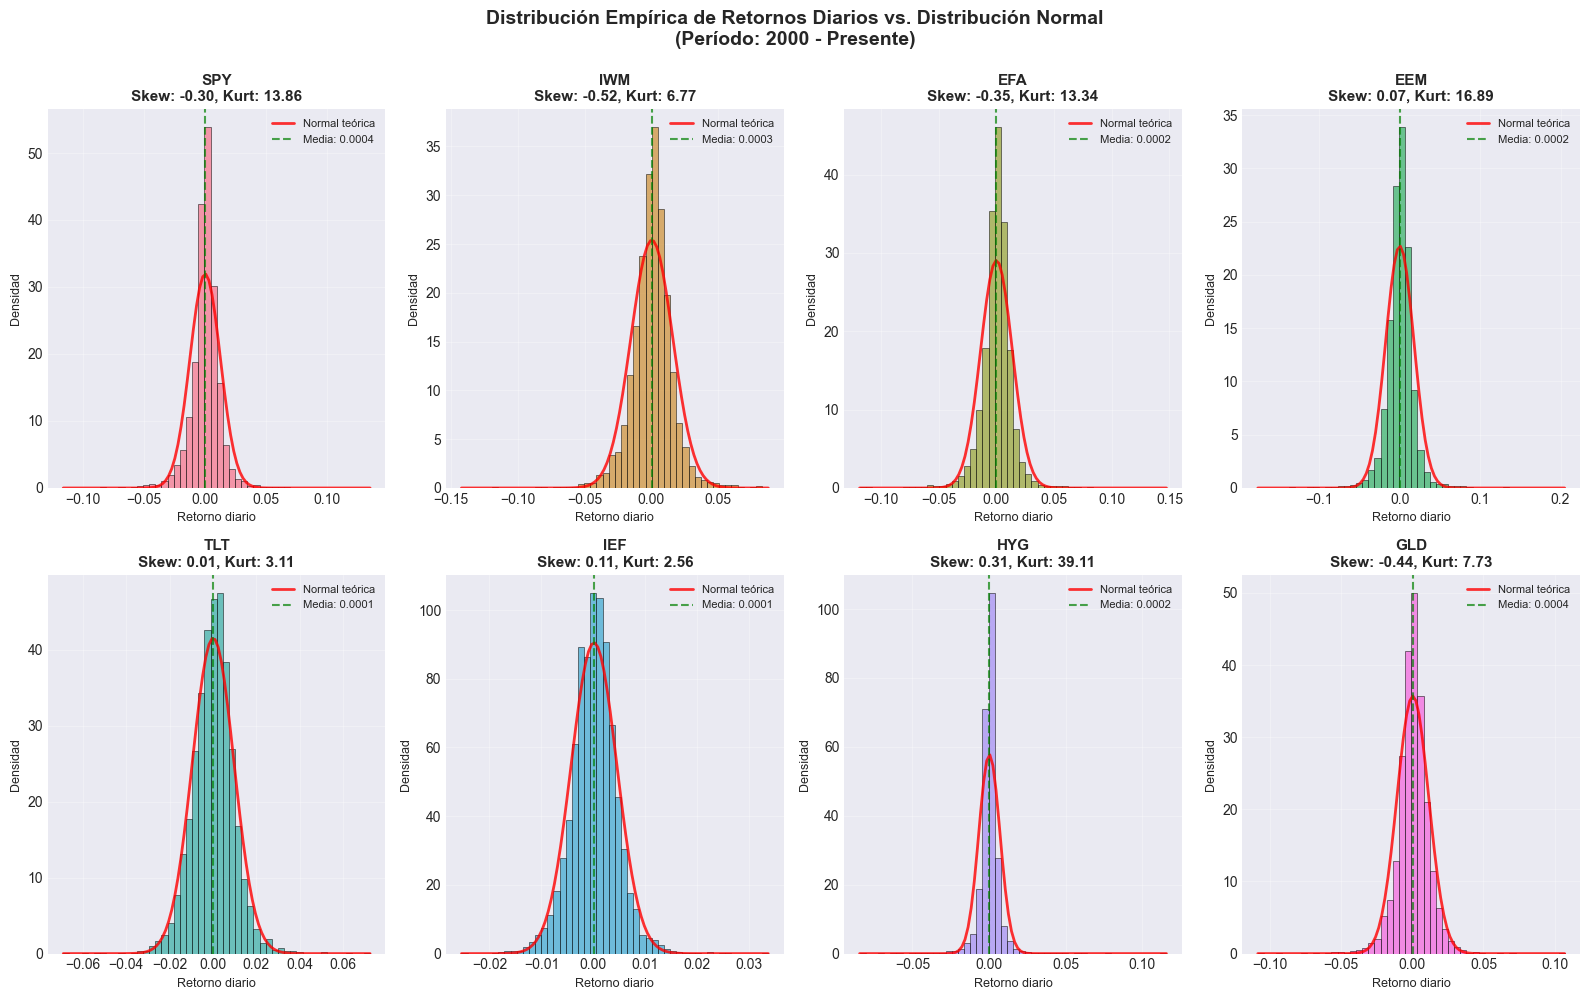

In [14]:
# Crear subplots para histogramas (2 filas x 4 columnas)
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for idx, ticker in enumerate(tickers):
    ax = axes[idx]
    
    # Datos del activo
    data = returns[ticker].dropna()
    mean = data.mean()
    std = data.std()
    
    # Histograma
    n, bins, patches = ax.hist(data, bins=50, density=True, alpha=0.7, 
                               color=sns.color_palette("husl", 8)[idx], 
                               edgecolor='black', linewidth=0.5)
    
    # Distribución normal teórica (usando solo numpy)
    # PDF normal: f(x) = (1 / (σ * sqrt(2π))) * exp(-0.5 * ((x - μ) / σ)^2)
    x = np.linspace(data.min(), data.max(), 100)
    normal_curve = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    ax.plot(x, normal_curve, 'r-', linewidth=2, label='Normal teórica', alpha=0.8)
    
    # Estadísticas en el gráfico
    skewness = data.skew()
    kurtosis = data.kurtosis()
    ax.axvline(mean, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label=f'Media: {mean:.4f}')
    
    ax.set_title(f'{ticker}\nSkew: {skewness:.2f}, Kurt: {kurtosis:.2f}', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Retorno diario', fontsize=9)
    ax.set_ylabel('Densidad', fontsize=9)
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)

plt.suptitle('Distribución Empírica de Retornos Diarios vs. Distribución Normal\n(Período: 2000 - Presente)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### Observaciones sobre No-Normalidad

**Asimetría (Skewness)**:
- Valores negativos significativos indican que las distribuciones tienen colas izquierdas más pesadas, lo que significa mayor probabilidad de pérdidas extremas que de ganancias extremas
- Esto es común en activos de riesgo y es un factor crítico para el stress testing

**Curtosis (Exceso de Curtosis)**:
- Valores positivos altos indican "colas pesadas" (fat tails), es decir, mayor probabilidad de eventos extremos de lo que predice una distribución normal
- Esto es una característica típica de los retornos financieros y tiene implicaciones importantes:
  - Los modelos basados en normalidad subestiman la probabilidad de eventos extremos
  - El VaR (Value at Risk) calculado bajo normalidad puede ser insuficiente
  - Se requieren técnicas de stress testing más robustas que capturen estos eventos extremos

**Implicaciones para Stress Testing**:
La no-normalidad observada justifica el uso de:
- Métodos históricos (Historical Simulation)
- Simulaciones Monte Carlo con distribuciones no normales
- Stress testing basado en escenarios históricos de crisis
- Modelos que capturen volatilidad cambiante (GARCH, modelos de régimen)

### 5.5. Volatilidad Rodante (Rolling Volatility)

La volatilidad rodante calcula la desviación estándar de retornos sobre una ventana móvil de tiempo. Utilizamos una ventana de 252 días (aproximadamente un año de trading) para capturar cambios en el régimen de volatilidad a lo largo del tiempo.

In [15]:
# Cálculo de volatilidad rodante (ventana de 252 días, anualizada)
rolling_window = 252
rolling_vol = returns.rolling(window=rolling_window).std() * np.sqrt(252)

print(f"Volatilidad rodante calculada (ventana: {rolling_window} días)")
print(f"Primeras {rolling_window} observaciones contienen NaN (ventana móvil)")
print(f"\nEstadísticas de volatilidad rodante (anualizada):")
print(rolling_vol.describe().round(4))

Volatilidad rodante calculada (ventana: 252 días)
Primeras 252 observaciones contienen NaN (ventana móvil)

Estadísticas de volatilidad rodante (anualizada):
             SPY        IWM        EFA        EEM        TLT        IEF  \
count  4481.0000  4481.0000  4481.0000  4481.0000  4481.0000  4481.0000   
mean      0.1819     0.2342     0.1991     0.2472     0.1504     0.0681   
std       0.0844     0.0922     0.0955     0.1324     0.0366     0.0190   
min       0.0673     0.1163     0.0760     0.1219     0.0870     0.0379   
25%       0.1241     0.1627     0.1324     0.1747     0.1250     0.0533   
50%       0.1600     0.2121     0.1698     0.1987     0.1437     0.0653   
75%       0.2023     0.2588     0.2384     0.2747     0.1806     0.0802   
max       0.4563     0.5230     0.5278     0.7467     0.2230     0.1120   

             HYG        GLD  
count  4481.0000  4481.0000  
mean      0.0928     0.1668  
std       0.0620     0.0510  
min       0.0337     0.0925  
25%       0.0550

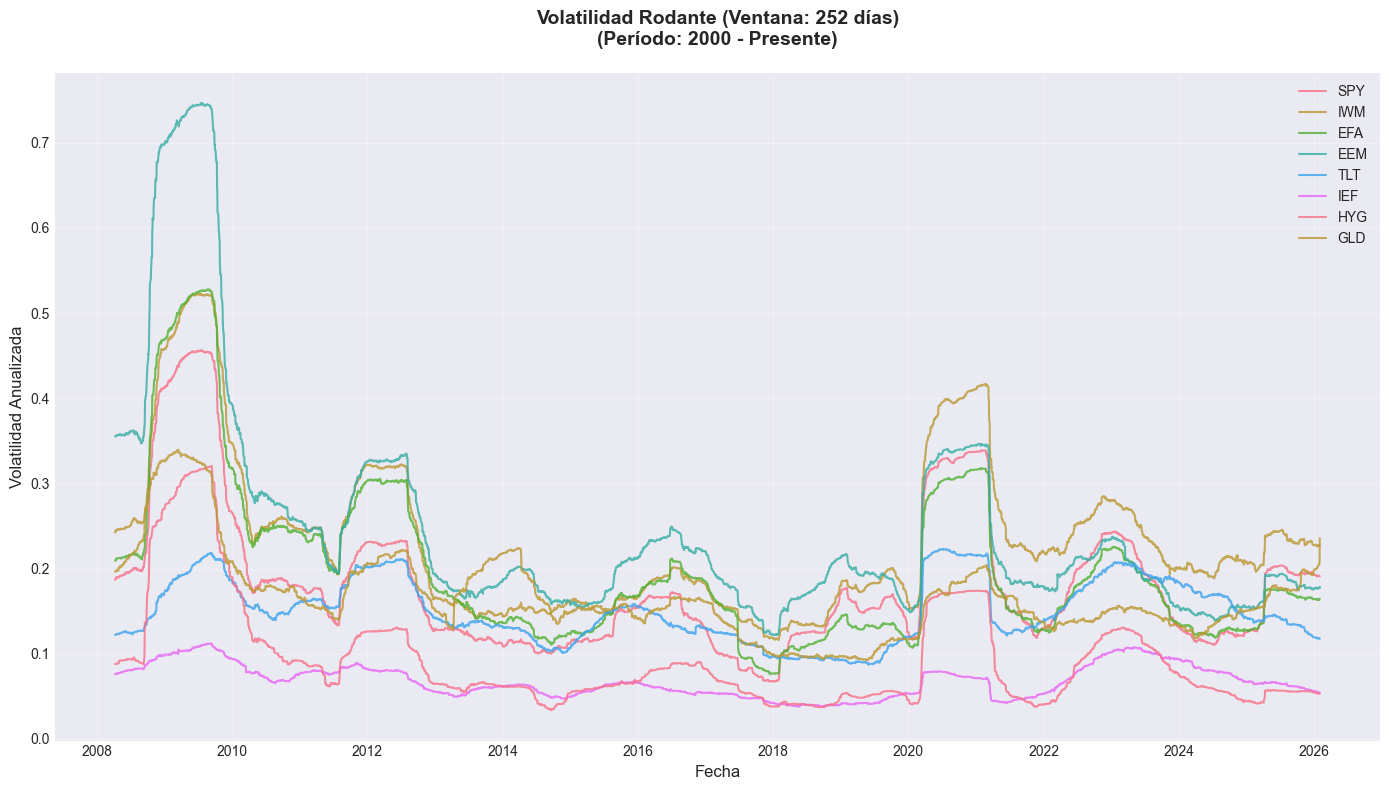

In [16]:
# Visualización: Volatilidad rodante para todos los activos
plt.figure(figsize=(14, 8))
for ticker in tickers:
    plt.plot(rolling_vol.index, rolling_vol[ticker], label=ticker, linewidth=1.5, alpha=0.8)

plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Volatilidad Anualizada', fontsize=12)
plt.title(f'Volatilidad Rodante (Ventana: {rolling_window} días)\n(Período: 2000 - Presente)', 
          fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Identificación de Períodos de Alta Volatilidad

El gráfico de volatilidad rodante permite identificar períodos históricos de estrés del mercado:

**Períodos típicos de alta volatilidad observados**:
1. **Crisis Financiera Global (2007-2009)**: Marcado aumento en volatilidad de todos los activos, especialmente acciones y bonos de alto rendimiento
2. **Crisis de Deuda Europea (2010-2012)**: Aumento en volatilidad de activos europeos y globales
3. **Flash Crash (2010)**: Breve pero significativo pico de volatilidad
4. **Crisis COVID-19 (2020)**: Aumento abrupto y significativo en volatilidad de todos los activos

**Observaciones clave**:
- **Clustering de volatilidad**: Los períodos de alta volatilidad tienden a agruparse, lo que sugiere que la volatilidad es persistente (característica capturada por modelos GARCH)
- **Diferencias entre activos**: Los bonos gubernamentales (TLT, IEF) típicamente muestran menor volatilidad que las acciones, pero pueden experimentar picos durante crisis de liquidez
- **Correlación de volatilidades**: Durante períodos de estrés, las volatilidades de diferentes activos tienden a aumentar simultáneamente, reduciendo los beneficios de diversificación

**Uso en Stress Testing**:
Estos períodos de alta volatilidad histórica pueden servir como:
- Escenarios de stress para pruebas de resistencia
- Validación de modelos de riesgo
- Calibración de parámetros de volatilidad en escenarios adversos

## Resumen de la Sección 1

### Datos Preparados

- **DataFrame `returns`**: Contiene retornos logarítmicos diarios de 8 ETFs desde 2000 hasta la fecha actual
- **Datos limpios**: Sin valores faltantes, con consistencia temporal verificada
- **Listo para análisis**: El DataFrame `returns` está disponible globalmente para uso en secciones posteriores

### Hallazgos Principales

1. **Características estadísticas**: Cada activo muestra perfiles de riesgo-retorno distintos, con acciones mostrando mayor volatilidad y retornos esperados que bonos gubernamentales

2. **Correlaciones**: Se observan patrones esperados de correlación intra-clase (alta) e inter-clase (baja o negativa), con cambios potenciales durante períodos de estrés

3. **No-normalidad**: Las distribuciones de retornos muestran asimetría negativa y colas pesadas, justificando el uso de métodos de stress testing robustos

4. **Volatilidad cambiante**: La volatilidad muestra clustering y períodos claramente identificables de estrés del mercado

### Próximos Pasos

En las siguientes secciones del sistema de stress testing, utilizaremos estos datos para:
- Construir modelos de riesgo (VaR, CVaR)
- Realizar simulaciones históricas de escenarios de stress
- Aplicar técnicas de Monte Carlo
- Analizar dependencias extremas (copulas)
- Evaluar el impacto de shocks en la cartera completa

In [17]:
# Verificación final: El DataFrame 'returns' está disponible para secciones posteriores
print("="*80)
print("VERIFICACIÓN FINAL")
print("="*80)
print(f"DataFrame 'returns' disponible: {'returns' in globals()}")
print(f"Dimensiones: {returns.shape}")
print(f"Columnas: {list(returns.columns)}")
print(f"Rango de fechas: {returns.index[0].strftime('%Y-%m-%d')} a {returns.index[-1].strftime('%Y-%m-%d')}")
print(f"Valores faltantes: {returns.isnull().sum().sum()}")
print("\n✓ Sección 1 completada. Datos listos para análisis de stress testing.")

VERIFICACIÓN FINAL
DataFrame 'returns' disponible: True
Dimensiones: (4732, 8)
Columnas: ['SPY', 'IWM', 'EFA', 'EEM', 'TLT', 'IEF', 'HYG', 'GLD']
Rango de fechas: 2007-04-12 a 2026-01-30
Valores faltantes: 0

✓ Sección 1 completada. Datos listos para análisis de stress testing.


---

## Sección 2: Identificación de Regímenes de Mercado mediante Hidden Markov Model

### Objetivo

Esta sección implementa un modelo de Hidden Markov Model (HMM) para identificar automáticamente dos estados distintos del mercado con interpretación económica clara: **Estado Normal** y **Estado de Crisis**.

**Aplicación en Gestión de Riesgos:**
- Identificación en tiempo real del régimen de mercado actual
- Ajuste dinámico de parámetros de riesgo según el estado identificado
- Detección temprana de transiciones hacia estados de crisis
- Validación de modelos de stress testing en diferentes regímenes

**Ventajas del HMM para identificación de regímenes:**
1. **Compatibilidad con tiempo real**: El modelo puede evaluar el estado actual basándose únicamente en observaciones históricas
2. **Modelado de persistencia**: Captura la tendencia de los mercados a permanecer en un estado durante períodos prolongados
3. **Probabilístico**: Proporciona probabilidades de transición entre estados, no solo asignaciones binarias
4. **No supervisado**: No requiere etiquetado manual de períodos de crisis, el modelo los identifica automáticamente basándose en características estadísticas

### Fundamentos del Hidden Markov Model

Un HMM es un modelo estadístico que asume que el sistema (mercado) puede estar en uno de varios estados ocultos (no observables directamente). En nuestro caso, identificamos dos estados: Normal y Crisis.

**Componentes del modelo:**
- **Estados ocultos**: Normal (0) y Crisis (1) - no observables directamente
- **Observaciones**: Retornos del mercado (SPY) - observables
- **Distribución de emisiones**: Para cada estado, los retornos siguen una distribución normal con media y varianza específicas
- **Matriz de transición**: Probabilidades de cambiar de un estado a otro en cada período

**Funcionamiento intuitivo:**
1. El mercado está en un estado (Normal o Crisis) en cada momento
2. Dependiendo del estado, los retornos observados tienen diferentes características estadísticas (mayor volatilidad en Crisis)
3. El modelo aprende estas características y las probabilidades de transición a partir de los datos históricos
4. Usando el algoritmo de Viterbi, identificamos la secuencia más probable de estados históricos

Este enfoque es superior a métodos simples de umbral porque captura la persistencia temporal: si el mercado está en crisis hoy, es más probable que siga en crisis mañana que si estuviera en estado normal.

In [20]:
# Importaciones adicionales para el modelo HMM
try:
    from hmmlearn import hmm
    HMMLEARN_AVAILABLE = True
    print("✓ hmmlearn disponible")
except ImportError:
    HMMLEARN_AVAILABLE = False
    print("⚠ hmmlearn no disponible. Usando implementación alternativa con sklearn.mixture")
    from sklearn.mixture import GaussianMixture

# Verificar que tenemos el DataFrame returns de la sección anterior
if 'returns' not in globals():
    raise ValueError("Error: El DataFrame 'returns' no está disponible. Ejecute primero la Sección 1.")

print(f"\nDataFrame 'returns' disponible con {len(returns)} observaciones")
print(f"Columnas: {list(returns.columns)}")

✓ hmmlearn disponible

DataFrame 'returns' disponible con 4732 observaciones
Columnas: ['SPY', 'IWM', 'EFA', 'EEM', 'TLT', 'IEF', 'HYG', 'GLD']


## 1. Preparación de Variable Observable para el HMM

El HMM requiere una variable observable que capture el estado de estrés del mercado. Utilizamos los retornos de SPY (S&P 500) como proxy del mercado de acciones estadounidense, que es representativo del estado general de los mercados financieros.

In [21]:
# Variable observable: retornos de SPY como proxy del mercado
observable_returns = returns['SPY'].dropna().values.reshape(-1, 1)

print(f"Variable observable preparada: retornos de SPY")
print(f"Número de observaciones: {len(observable_returns)}")
print(f"Rango de fechas: {returns['SPY'].dropna().index[0].strftime('%Y-%m-%d')} a {returns['SPY'].dropna().index[-1].strftime('%Y-%m-%d')}")
print(f"\nEstadísticas de retornos de SPY:")
print(f"  Media: {observable_returns.mean():.6f}")
print(f"  Desviación estándar: {observable_returns.std():.6f}")
print(f"  Mínimo: {observable_returns.min():.6f}")
print(f"  Máximo: {observable_returns.max():.6f}")

# Guardar fechas correspondientes para uso posterior
observable_dates = returns['SPY'].dropna().index

Variable observable preparada: retornos de SPY
Número de observaciones: 4732
Rango de fechas: 2007-04-12 a 2026-01-30

Estadísticas de retornos de SPY:
  Media: 0.000405
  Desviación estándar: 0.012489
  Mínimo: -0.115886
  Máximo: 0.135578


## 2. Configuración y Ajuste del Hidden Markov Model

Configuramos un HMM con exactamente 2 estados. El modelo estimará:
- Media y varianza de retornos para cada estado
- Probabilidades iniciales de comenzar en cada estado
- Matriz de transición entre estados

In [23]:
# Configuración del HMM
n_states = 2  # Exactamente 2 estados: Normal y Crisis

if HMMLEARN_AVAILABLE:
    # Usar hmmlearn (método preferido)
    print("Configurando HMM con hmmlearn...")
    
    # Inicialización inteligente basada en estadísticas de los datos
    # Estado 0 (Normal): media cercana a la media global, varianza baja
    # Estado 1 (Crisis): media más negativa, varianza alta
    means_init = np.array([
        [observable_returns.mean()],  # Estado Normal: media global
        [observable_returns.mean() - 2 * observable_returns.std()]  # Estado Crisis: media más negativa
    ])
    
    # Varianzas iniciales
    covars_init = np.array([
        [[observable_returns.var() * 0.5]],  # Estado Normal: varianza baja
        [[observable_returns.var() * 2.0]]   # Estado Crisis: varianza alta
    ])
    
    # Crear el modelo (hmmlearn no acepta means_init/covars_init en el constructor)
    model = hmm.GaussianHMM(
        n_components=n_states,
        covariance_type="full",
        n_iter=1000,
        tol=1e-6,
        random_state=42
    )
    
    # Establecer valores iniciales directamente en los atributos antes de ajustar
    model.means_ = means_init
    model.covars_ = covars_init
    
    print("Ajustando el modelo a los datos históricos...")
    model.fit(observable_returns)
    
    print(f"✓ Modelo ajustado exitosamente después de {model.n_iter} iteraciones")
    print(f"  Log-likelihood final: {model.score(observable_returns):.2f}")
    
else:
    # Implementación alternativa usando GaussianMixture (no es HMM real pero puede servir)
    print("⚠ Usando GaussianMixture como alternativa (no es un HMM completo)")
    print("  Nota: Esto no modela transiciones de estado, solo identifica dos regímenes")
    
    model = GaussianMixture(n_components=n_states, random_state=42, max_iter=1000)
    model.fit(observable_returns)
    
    print(f"✓ Modelo ajustado exitosamente")
    print(f"  Log-likelihood final: {model.score(observable_returns):.2f}")

Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'


Configurando HMM con hmmlearn...
Ajustando el modelo a los datos históricos...


Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Model is not converging.  Current: 15142.718136750167 is not greater than 15142.798399856243. Delta is -0.08026310607601772


✓ Modelo ajustado exitosamente después de 1000 iteraciones
  Log-likelihood final: 15142.61


## 3. Predicción de Estados Históricos

Utilizamos el algoritmo de Viterbi para identificar la secuencia más probable de estados históricos. Este algoritmo encuentra la secuencia de estados que maximiza la probabilidad conjunta dados los retornos observados.

In [24]:
# Predicción de estados usando algoritmo de Viterbi
if HMMLEARN_AVAILABLE:
    states = model.predict(observable_returns)
    state_probs = model.predict_proba(observable_returns)
else:
    # Con GaussianMixture, usar predict directamente
    states = model.predict(observable_returns)
    state_probs = model.predict_proba(observable_returns)

print(f"Estados predichos para {len(states)} observaciones")
print(f"\nDistribución de estados:")
unique, counts = np.unique(states, return_counts=True)
for state, count in zip(unique, counts):
    pct = 100 * count / len(states)
    print(f"  Estado {state}: {count} observaciones ({pct:.2f}%)")

# Crear DataFrame con estados para facilitar análisis posterior
states_df = pd.DataFrame({
    'state': states,
    'date': observable_dates
})
states_df.set_index('date', inplace=True)

Estados predichos para 4732 observaciones

Distribución de estados:
  Estado 0: 3658 observaciones (77.30%)
  Estado 1: 1074 observaciones (22.70%)


## 4. Identificación y Etiquetado de Estados

Identificamos qué estado corresponde a "Normal" y cuál a "Crisis" basándonos en las características estadísticas observadas. El estado con mayor volatilidad media se etiqueta como "Crisis".

In [25]:
# Calcular estadísticas por estado para identificar Normal vs Crisis
state_stats = {}
for state in range(n_states):
    mask = states == state
    state_returns = observable_returns[mask.flatten()]
    
    state_stats[state] = {
        'mean': state_returns.mean(),
        'std': state_returns.std(),
        'volatility_annualized': state_returns.std() * np.sqrt(252),
        'count': len(state_returns),
        'pct': 100 * len(state_returns) / len(states)
    }

print("Estadísticas por estado (antes de etiquetado):")
print("="*70)
for state in range(n_states):
    stats = state_stats[state]
    print(f"\nEstado {state}:")
    print(f"  Observaciones: {stats['count']} ({stats['pct']:.2f}%)")
    print(f"  Media diaria: {stats['mean']:.6f}")
    print(f"  Volatilidad diaria: {stats['std']:.6f}")
    print(f"  Volatilidad anualizada: {stats['volatility_annualized']:.4f}")

# Identificar qué estado es Crisis (mayor volatilidad)
volatilities = [state_stats[s]['volatility_annualized'] for s in range(n_states)]
crisis_state = np.argmax(volatilities)
normal_state = 1 - crisis_state

# Crear mapeo de etiquetas
state_labels = {
    normal_state: 'Normal',
    crisis_state: 'Crisis'
}

print("\n" + "="*70)
print("IDENTIFICACIÓN DE ESTADOS:")
print("="*70)
print(f"Estado Normal: Estado {normal_state} (volatilidad: {state_stats[normal_state]['volatility_annualized']:.4f})")
print(f"Estado Crisis: Estado {crisis_state} (volatilidad: {state_stats[crisis_state]['volatility_annualized']:.4f})")

# Verificar que la identificación tiene sentido económico
if state_stats[crisis_state]['volatility_annualized'] > state_stats[normal_state]['volatility_annualized']:
    print("\n✓ Validación: El estado Crisis tiene mayor volatilidad que Normal (correcto)")
else:
    print("\n⚠ Advertencia: La identificación podría estar invertida")

Estadísticas por estado (antes de etiquetado):

Estado 0:
  Observaciones: 3658 (77.30%)
  Media diaria: 0.000987
  Volatilidad diaria: 0.007337
  Volatilidad anualizada: 0.1165

Estado 1:
  Observaciones: 1074 (22.70%)
  Media diaria: -0.001576
  Volatilidad diaria: 0.022334
  Volatilidad anualizada: 0.3545

IDENTIFICACIÓN DE ESTADOS:
Estado Normal: Estado 0 (volatilidad: 0.1165)
Estado Crisis: Estado 1 (volatilidad: 0.3545)

✓ Validación: El estado Crisis tiene mayor volatilidad que Normal (correcto)


## 5. Matriz de Transición y Persistencia de Estados

La matriz de transición contiene las probabilidades de cambiar de un estado a otro. Valores altos en la diagonal principal indican alta persistencia (el mercado tiende a permanecer en el mismo estado).

In [26]:
# Extraer matriz de transición
if HMMLEARN_AVAILABLE:
    transition_matrix = model.transmat_
else:
    # Con GaussianMixture no hay matriz de transición real
    # Calcular empíricamente desde la secuencia de estados
    transition_matrix = np.zeros((n_states, n_states))
    for i in range(len(states) - 1):
        transition_matrix[states[i], states[i+1]] += 1
    # Normalizar por filas
    row_sums = transition_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Evitar división por cero
    transition_matrix = transition_matrix / row_sums

# Crear DataFrame para mejor visualización
transition_df = pd.DataFrame(
    transition_matrix,
    index=[f"Estado {i} ({state_labels[i]})" for i in range(n_states)],
    columns=[f"Estado {i} ({state_labels[i]})" for i in range(n_states)]
)

print("Matriz de Transición entre Estados")
print("="*70)
print(transition_df.round(4))
print("\nInterpretación:")
print("- Valores en la diagonal: probabilidad de permanecer en el mismo estado")
print("- Valores fuera de la diagonal: probabilidad de transición a otro estado")

# Calcular persistencia (probabilidad de permanecer en el mismo estado)
persistence = {}
for state in range(n_states):
    persistence[state_labels[state]] = transition_matrix[state, state]

print("\nPersistencia de Estados:")
for state_name, prob in persistence.items():
    print(f"  {state_name}: {prob:.4f} ({prob*100:.2f}%)")
    
# Calcular duración esperada en cada estado (en días)
# Duración esperada = 1 / (1 - probabilidad de permanecer)
expected_duration = {}
for state in range(n_states):
    p_stay = transition_matrix[state, state]
    if p_stay < 1.0:
        duration = 1 / (1 - p_stay)
        expected_duration[state_labels[state]] = duration
    else:
        expected_duration[state_labels[state]] = np.inf

print("\nDuración Esperada en cada Estado (días):")
for state_name, duration in expected_duration.items():
    if np.isfinite(duration):
        print(f"  {state_name}: {duration:.1f} días ({duration/252:.2f} años)")
    else:
        print(f"  {state_name}: Infinito (estado absorbente)")

Matriz de Transición entre Estados
                   Estado 0 (Normal)  Estado 1 (Crisis)
Estado 0 (Normal)             0.9863             0.0137
Estado 1 (Crisis)             0.0447             0.9553

Interpretación:
- Valores en la diagonal: probabilidad de permanecer en el mismo estado
- Valores fuera de la diagonal: probabilidad de transición a otro estado

Persistencia de Estados:
  Normal: 0.9863 (98.63%)
  Crisis: 0.9553 (95.53%)

Duración Esperada en cada Estado (días):
  Normal: 72.8 días (0.29 años)
  Crisis: 22.4 días (0.09 años)


### Interpretación de la Persistencia

**Alta persistencia** (valores cercanos a 1 en la diagonal) indica que:
- Una vez que el mercado entra en un estado, tiende a permanecer en él durante períodos prolongados
- Las transiciones entre estados son relativamente infrecuentes
- Esto es consistente con la observación empírica de que los períodos de crisis y normalidad tienden a agruparse temporalmente

**Implicaciones para gestión de riesgos:**
- Si el mercado está en estado Normal, es probable que continúe en Normal en el corto plazo
- Si el mercado entra en Crisis, es probable que permanezca en Crisis durante un período significativo
- Las transiciones hacia Crisis requieren monitoreo especial, ya que indican cambios de régimen

## 6. Estadísticas Condicionales de Retornos por Activo

Analizamos cómo se comportan los retornos de cada activo condicionados al estado del mercado. Esto permite identificar qué activos son más sensibles a los cambios de régimen.

In [27]:
# Alinear estados con retornos de todos los activos
# Asegurar que las fechas coincidan
returns_aligned = returns.loc[observable_dates]

# Calcular estadísticas condicionales por activo y estado
returns_by_state = {}
conditional_stats = {}

for state_num, state_name in state_labels.items():
    mask = states == state_num
    state_dates = observable_dates[mask]
    
    # Retornos en este estado
    state_returns = returns_aligned.loc[state_dates]
    returns_by_state[state_name] = state_returns
    
    # Estadísticas por activo
    stats_dict = {}
    for ticker in returns.columns:
        ticker_returns = state_returns[ticker].dropna()
        if len(ticker_returns) > 0:
            stats_dict[ticker] = {
                'mean_daily': ticker_returns.mean(),
                'mean_annualized': ticker_returns.mean() * 252,
                'volatility_daily': ticker_returns.std(),
                'volatility_annualized': ticker_returns.std() * np.sqrt(252),
                'skewness': ticker_returns.skew(),
                'min': ticker_returns.min(),
                'max': ticker_returns.max(),
                'count': len(ticker_returns)
            }
    
    conditional_stats[state_name] = stats_dict

# Crear DataFrame comparativo
comparison_data = []
for ticker in returns.columns:
    for state_name in state_labels.values():
        if ticker in conditional_stats[state_name]:
            stats = conditional_stats[state_name][ticker]
            comparison_data.append({
                'Ticker': ticker,
                'Estado': state_name,
                'Media Anualizada': stats['mean_annualized'],
                'Volatilidad Anualizada': stats['volatility_annualized'],
                'Asimetría': stats['skewness'],
                'Observaciones': stats['count']
            })

comparison_df = pd.DataFrame(comparison_data)

print("Estadísticas Condicionales de Retornos por Activo y Estado")
print("="*80)
print(comparison_df.round(4))

Estadísticas Condicionales de Retornos por Activo y Estado
   Ticker  Estado  Media Anualizada  Volatilidad Anualizada  Asimetría  \
0     SPY  Normal            0.2487                  0.1165    -0.1932   
1     SPY  Crisis           -0.3971                  0.3547     0.0338   
2     IWM  Normal            0.2425                  0.1703    -0.0296   
3     IWM  Crisis           -0.4910                  0.4167    -0.2672   
4     EFA  Normal            0.1756                  0.1396    -0.1988   
5     EFA  Crisis           -0.4050                  0.3770    -0.0732   
6     EEM  Normal            0.1725                  0.1768    -0.1137   
7     EEM  Crisis           -0.4033                  0.4851     0.2298   
8     TLT  Normal           -0.0039                  0.1322    -0.1990   
9     TLT  Crisis            0.1475                  0.2069     0.1253   
10    IEF  Normal            0.0116                  0.0612    -0.1141   
11    IEF  Crisis            0.1057                  

## 7. Matrices de Correlación Condicionales

Las correlaciones entre activos pueden cambiar significativamente entre estados Normal y Crisis. Durante crisis, las correlaciones típicamente aumentan (efecto contagio), reduciendo los beneficios de diversificación.

In [28]:
# Calcular matrices de correlación para cada estado
correlation_by_state = {}

for state_name in state_labels.values():
    state_returns = returns_by_state[state_name]
    correlation_by_state[state_name] = state_returns.corr()

print("Matrices de Correlación por Estado")
print("="*80)

for state_name in state_labels.values():
    print(f"\n{state_name.upper()} ({len(returns_by_state[state_name])} observaciones):")
    print(correlation_by_state[state_name].round(4))
    
# Calcular diferencia en correlaciones
corr_diff = correlation_by_state['Crisis'] - correlation_by_state['Normal']
print("\n" + "="*80)
print("DIFERENCIA EN CORRELACIONES (Crisis - Normal)")
print("="*80)
print("Valores positivos indican mayor correlación en Crisis (efecto contagio)")
print(corr_diff.round(4))

Matrices de Correlación por Estado

NORMAL (3658 observaciones):
        SPY     IWM     EFA     EEM     TLT     IEF     HYG     GLD
SPY  1.0000  0.8273  0.8040  0.7200 -0.2346 -0.2310  0.6409  0.0730
IWM  0.8273  1.0000  0.7009  0.6287 -0.2075 -0.2044  0.5656  0.0714
EFA  0.8040  0.7009  1.0000  0.7954 -0.1965 -0.1658  0.5964  0.2100
EEM  0.7200  0.6287  0.7954  1.0000 -0.1636 -0.1489  0.5460  0.2452
TLT -0.2346 -0.2075 -0.1965 -0.1636  1.0000  0.9157  0.0138  0.1977
IEF -0.2310 -0.2044 -0.1658 -0.1489  0.9157  1.0000  0.0437  0.2558
HYG  0.6409  0.5656  0.5964  0.5460  0.0138  0.0437  1.0000  0.1175
GLD  0.0730  0.0714  0.2100  0.2452  0.1977  0.2558  0.1175  1.0000

CRISIS (1074 observaciones):
        SPY     IWM     EFA     EEM     TLT     IEF     HYG     GLD
SPY  1.0000  0.9338  0.9230  0.8712 -0.4016 -0.3892  0.6966  0.0361
IWM  0.9338  1.0000  0.8742  0.8299 -0.3913 -0.3791  0.6565  0.0262
EFA  0.9230  0.8742  1.0000  0.9150 -0.3996 -0.3861  0.6898  0.1055
EEM  0.8712  0.8299  

## 8. Visualizaciones

### 8.1. Serie Temporal con Regímenes Identificados

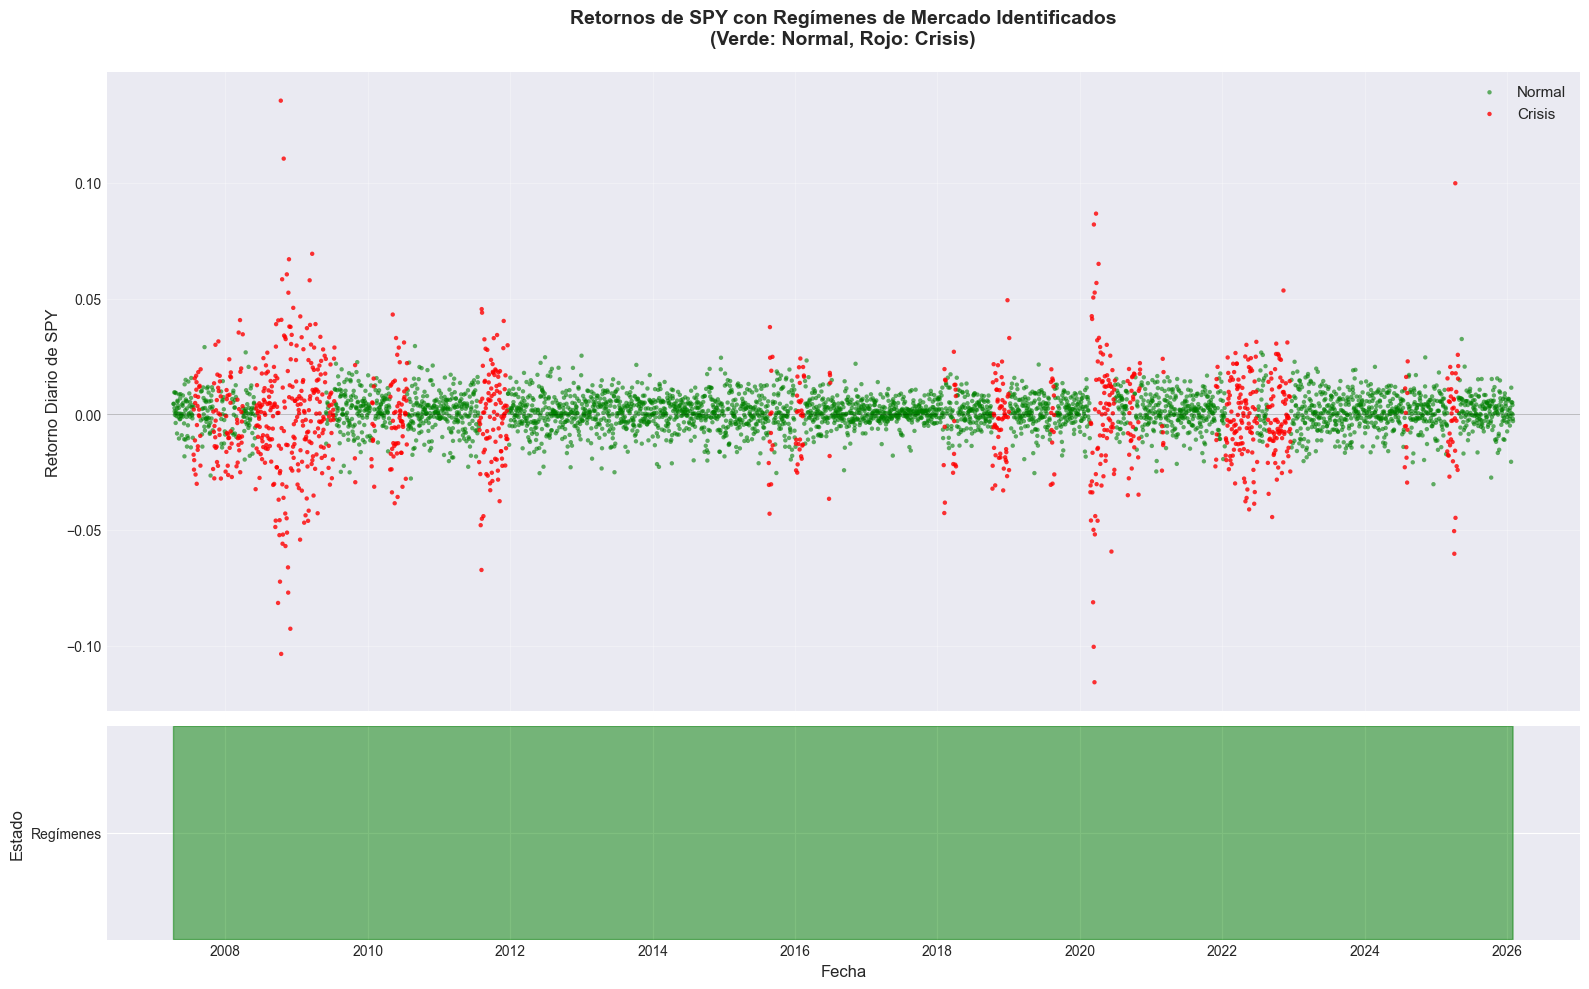


Períodos identificados por estado:

Normal:
  Primer fecha: 2007-04-12
  Última fecha: 2026-01-30
  Total de días: 3658
  Proporción temporal: 77.30%

Crisis:
  Primer fecha: 2007-07-24
  Última fecha: 2025-04-24
  Total de días: 1074
  Proporción temporal: 22.70%


In [29]:
# Visualización: Serie temporal de retornos de SPY con código de colores por estado
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True, height_ratios=[3, 1])

# Gráfico superior: Retornos de SPY con colores según estado
for state_num, state_name in state_labels.items():
    mask = states == state_num
    state_dates = observable_dates[mask]
    state_returns = observable_returns[mask.flatten()]
    
    color = 'green' if state_name == 'Normal' else 'red'
    alpha = 0.6 if state_name == 'Normal' else 0.8
    ax1.scatter(state_dates, state_returns, c=color, label=state_name, 
               alpha=alpha, s=10, edgecolors='none')

ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax1.set_ylabel('Retorno Diario de SPY', fontsize=12)
ax1.set_title('Retornos de SPY con Regímenes de Mercado Identificados\n(Verde: Normal, Rojo: Crisis)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.legend(loc='upper right', fontsize=11)
ax1.grid(True, alpha=0.3)

# Gráfico inferior: Indicador de estado
state_colors = ['green' if s == normal_state else 'red' for s in states]
ax2.fill_between(observable_dates, 0, 1, color=state_colors, alpha=0.5)
ax2.set_ylabel('Estado', fontsize=12)
ax2.set_xlabel('Fecha', fontsize=12)
ax2.set_yticks([0.5])
ax2.set_yticklabels(['Regímenes'])
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Estadísticas de períodos
print("\nPeríodos identificados por estado:")
print("="*70)
for state_name in state_labels.values():
    state_mask = states == [k for k, v in state_labels.items() if v == state_name][0]
    state_dates = observable_dates[state_mask]
    if len(state_dates) > 0:
        print(f"\n{state_name}:")
        print(f"  Primer fecha: {state_dates[0].strftime('%Y-%m-%d')}")
        print(f"  Última fecha: {state_dates[-1].strftime('%Y-%m-%d')}")
        print(f"  Total de días: {len(state_dates)}")
        print(f"  Proporción temporal: {100*len(state_dates)/len(states):.2f}%")

### 8.2. Histogramas Comparativos de Retornos de SPY

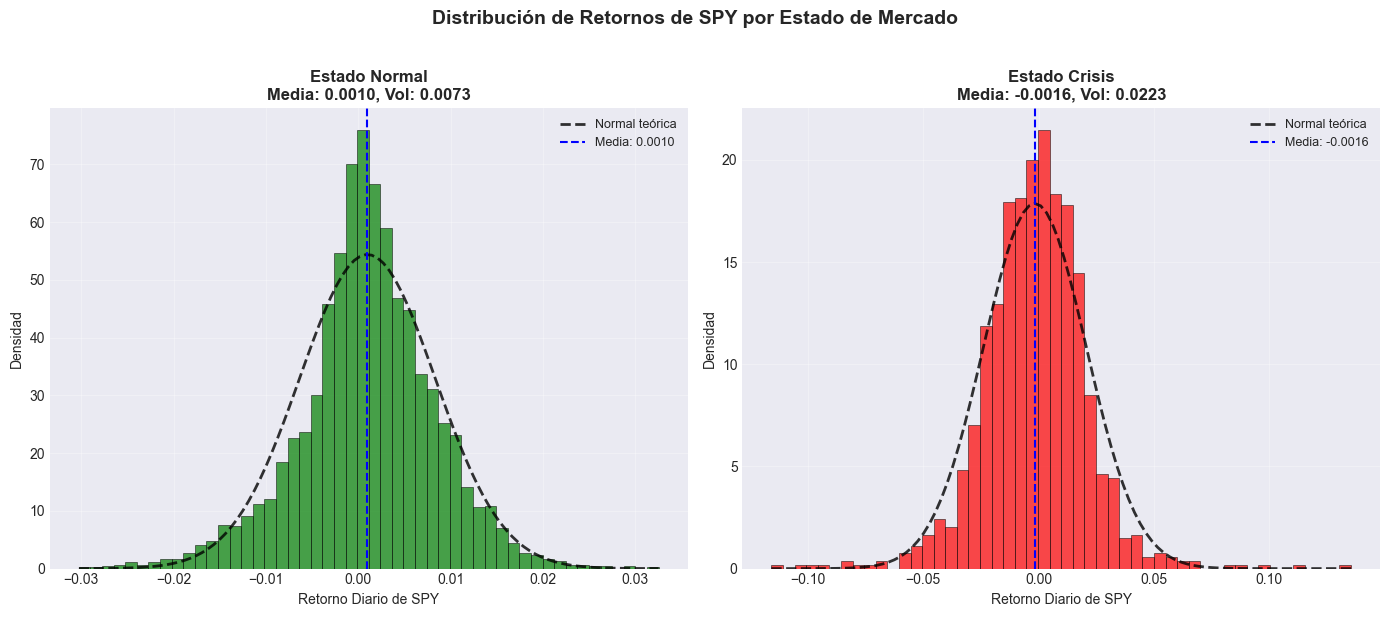

In [30]:
# Histogramas comparativos de retornos de SPY en cada estado
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (state_name, state_num) in enumerate([(v, k) for k, v in state_labels.items()]):
    ax = axes[idx]
    mask = states == state_num
    state_returns = observable_returns[mask.flatten()]
    
    # Histograma
    ax.hist(state_returns, bins=50, density=True, alpha=0.7, 
           color='green' if state_name == 'Normal' else 'red',
           edgecolor='black', linewidth=0.5)
    
    # Estadísticas
    mean = state_returns.mean()
    std = state_returns.std()
    
    # Curva normal teórica
    x = np.linspace(state_returns.min(), state_returns.max(), 100)
    normal_curve = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    ax.plot(x, normal_curve, 'k--', linewidth=2, label='Normal teórica', alpha=0.8)
    
    ax.axvline(mean, color='blue', linestyle='--', linewidth=1.5, label=f'Media: {mean:.4f}')
    
    ax.set_title(f'Estado {state_name}\nMedia: {mean:.4f}, Vol: {std:.4f}', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Retorno Diario de SPY', fontsize=10)
    ax.set_ylabel('Densidad', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Distribución de Retornos de SPY por Estado de Mercado', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 8.3. Heatmaps de Correlación: Normal vs Crisis

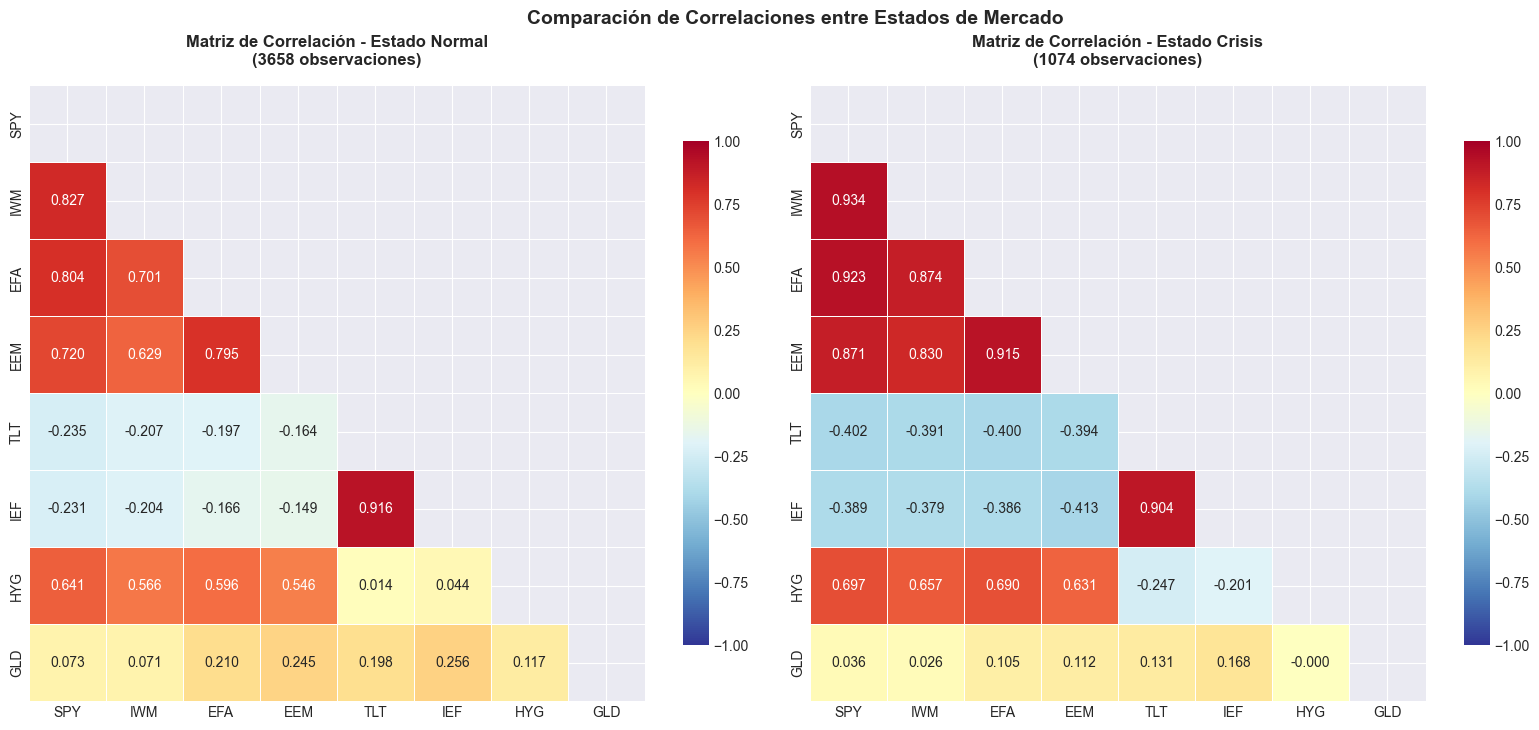

In [31]:
# Heatmaps lado a lado de correlación en cada estado
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for idx, state_name in enumerate(['Normal', 'Crisis']):
    ax = axes[idx]
    corr_matrix = correlation_by_state[state_name]
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                center=0, vmin=-1, vmax=1, square=True, linewidths=0.5,
                cbar_kws={"shrink": 0.8}, mask=mask, ax=ax)
    
    ax.set_title(f'Matriz de Correlación - Estado {state_name}\n({len(returns_by_state[state_name])} observaciones)', 
                 fontsize=12, fontweight='bold', pad=15)

plt.suptitle('Comparación de Correlaciones entre Estados de Mercado', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 8.4. Volatilidad Media por Activo en cada Estado

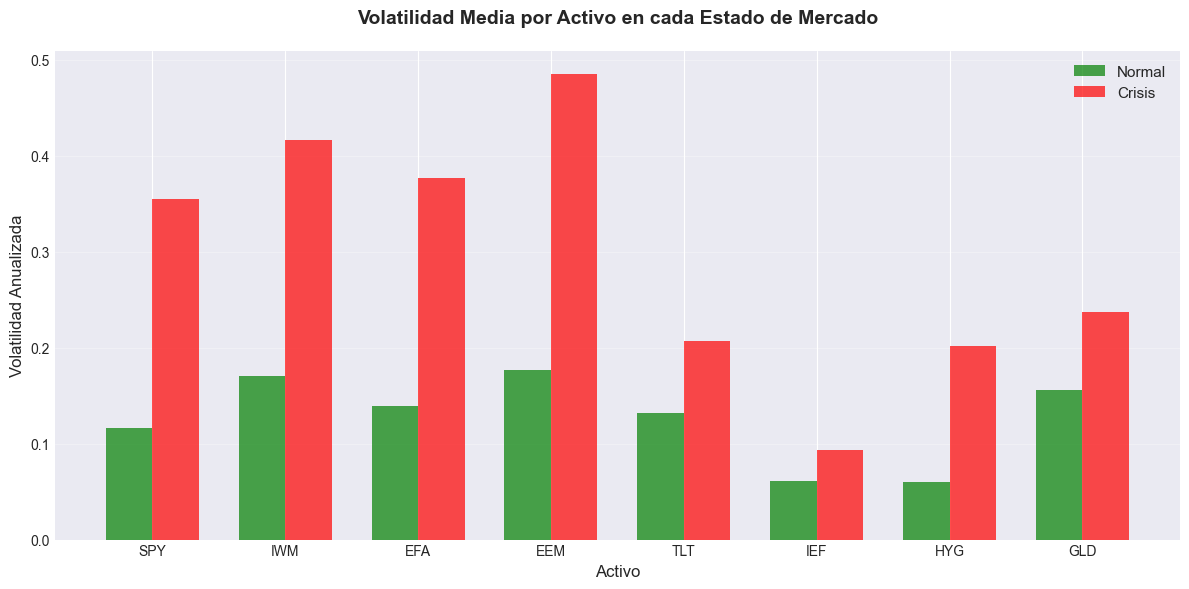

In [32]:
# Gráfico de barras: volatilidad anualizada por activo en cada estado
volatility_data = []
for ticker in returns.columns:
    for state_name in ['Normal', 'Crisis']:
        if ticker in conditional_stats[state_name]:
            vol = conditional_stats[state_name][ticker]['volatility_annualized']
            volatility_data.append({
                'Ticker': ticker,
                'Estado': state_name,
                'Volatilidad': vol
            })

vol_df = pd.DataFrame(volatility_data)

# Crear gráfico de barras agrupadas
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(returns.columns))
width = 0.35

normal_vols = [vol_df[(vol_df['Ticker'] == ticker) & (vol_df['Estado'] == 'Normal')]['Volatilidad'].values[0] 
               if len(vol_df[(vol_df['Ticker'] == ticker) & (vol_df['Estado'] == 'Normal')]) > 0 else 0
               for ticker in returns.columns]
crisis_vols = [vol_df[(vol_df['Ticker'] == ticker) & (vol_df['Estado'] == 'Crisis')]['Volatilidad'].values[0] 
               if len(vol_df[(vol_df['Ticker'] == ticker) & (vol_df['Estado'] == 'Crisis')]) > 0 else 0
               for ticker in returns.columns]

bars1 = ax.bar(x - width/2, normal_vols, width, label='Normal', color='green', alpha=0.7)
bars2 = ax.bar(x + width/2, crisis_vols, width, label='Crisis', color='red', alpha=0.7)

ax.set_xlabel('Activo', fontsize=12)
ax.set_ylabel('Volatilidad Anualizada', fontsize=12)
ax.set_title('Volatilidad Media por Activo en cada Estado de Mercado', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(returns.columns)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 9. Identificación de Eventos Históricos

Verificamos que los períodos identificados como "Crisis" coinciden con eventos históricos conocidos de estrés del mercado.

In [34]:
# Identificar períodos continuos de crisis
crisis_mask = states == crisis_state
crisis_dates = observable_dates[crisis_mask]

# Encontrar períodos continuos de crisis
crisis_periods = []
in_crisis = False
start_date = None

for i, (date, is_crisis) in enumerate(zip(observable_dates, crisis_mask)):
    if is_crisis and not in_crisis:
        # Inicio de período de crisis
        start_date = date
        in_crisis = True
    elif not is_crisis and in_crisis:
        # Fin de período de crisis
        end_date = observable_dates[i-1]
        duration = (end_date - start_date).days
        crisis_periods.append({
            'start': start_date,
            'end': end_date,
            'duration_days': duration,
            'duration_years': duration / 252
        })
        in_crisis = False

# Si terminamos en crisis, agregar el último período
if in_crisis:
    end_date = observable_dates[-1]
    duration = (end_date - start_date).days
    crisis_periods.append({
        'start': start_date,
        'end': end_date,
        'duration_days': duration,
        'duration_years': duration / 252
    })

print("Períodos Históricos Identificados como Crisis")
print("="*80)
for i, period in enumerate(crisis_periods, 1):
    print(f"\nCrisis {i}:")
    print(f"  Inicio: {period['start'].strftime('%Y-%m-%d')}")
    print(f"  Fin: {period['end'].strftime('%Y-%m-%d')}")
    print(f"  Duración: {period['duration_days']} días ({period['duration_years']:.2f} años)")

# Eventos históricos conocidos para comparación
known_events = {
    '2007-10-01': 'Inicio Crisis Financiera Global',
    '2008-09-15': 'Quiebra de Lehman Brothers',
    '2009-03-09': 'Mínimo del mercado post-crisis',
    '2010-05-06': 'Flash Crash',
    '2011-08-01': 'Crisis de Deuda Europea',
    '2015-08-24': 'Flash Crash China',
    '2020-03-23': 'Mínimo COVID-19',
    '2022-01-03': 'Inicio corrección 2022'
}

print("\n" + "="*80)
print("Comparación con Eventos Históricos Conocidos:")
print("="*80)
for event_date_str, event_name in known_events.items():
    event_date = pd.to_datetime(event_date_str)
    if event_date >= observable_dates[0] and event_date <= observable_dates[-1]:
        # Encontrar el estado en esa fecha
        # Convertir TimedeltaIndex a valores numéricos para poder usar abs()
        time_diffs = pd.Series(observable_dates - event_date).abs()
        closest_idx = time_diffs.argmin()
        state_at_event = states[closest_idx]
        state_name = state_labels[state_at_event]
        marker = "✓" if state_name == 'Crisis' else "✗"
        print(f"{marker} {event_date_str}: {event_name} - Estado identificado: {state_name}")

Períodos Históricos Identificados como Crisis

Crisis 1:
  Inicio: 2007-07-24
  Fin: 2007-08-29
  Duración: 36 días (0.14 años)

Crisis 2:
  Inicio: 2007-11-01
  Fin: 2007-12-11
  Duración: 40 días (0.16 años)

Crisis 3:
  Inicio: 2008-01-04
  Fin: 2008-02-05
  Duración: 32 días (0.13 años)

Crisis 4:
  Inicio: 2008-02-29
  Fin: 2008-04-01
  Duración: 32 días (0.13 años)

Crisis 5:
  Inicio: 2008-06-05
  Fin: 2009-06-01
  Duración: 361 días (1.43 años)

Crisis 6:
  Inicio: 2009-06-15
  Fin: 2009-07-15
  Duración: 30 días (0.12 años)

Crisis 7:
  Inicio: 2009-10-28
  Fin: 2009-10-30
  Duración: 2 días (0.01 años)

Crisis 8:
  Inicio: 2010-01-21
  Fin: 2010-02-04
  Duración: 14 días (0.06 años)

Crisis 9:
  Inicio: 2010-04-27
  Fin: 2010-07-22
  Duración: 86 días (0.34 años)

Crisis 10:
  Inicio: 2011-07-27
  Fin: 2011-12-20
  Duración: 146 días (0.58 años)

Crisis 11:
  Inicio: 2015-08-20
  Fin: 2015-09-09
  Duración: 20 días (0.08 años)

Crisis 12:
  Inicio: 2016-01-06
  Fin: 2016-02-1

In [36]:
# Verificación final de variables clave
print("="*80)
print("VERIFICACIÓN DE VARIABLES PARA SECCIONES POSTERIORES")
print("="*80)

variables_to_check = {
    'states': 'Secuencia histórica de estados identificados',
    'state_labels': 'Mapeo de estados a etiquetas (Normal/Crisis)',
    'transition_matrix': 'Matriz de transición entre estados',
    'returns_by_state': 'Retornos segregados por estado',
    'observable_dates': 'Fechas correspondientes a los estados'
}

for var_name, description in variables_to_check.items():
    exists = var_name in globals()
    status = "✓" if exists else "✗"
    print(f"{status} {var_name}: {description}")
    if exists:
        if var_name == 'states':
            print(f"    Tipo: {type(globals()[var_name])}, Longitud: {len(globals()[var_name])}")
        elif var_name == 'state_labels':
            print(f"    Contenido: {globals()[var_name]}")
        elif var_name == 'transition_matrix':
            print(f"    Dimensiones: {globals()[var_name].shape}")
        elif var_name == 'returns_by_state':
            states_in_dict = list(globals()[var_name].keys())
            print(f"    Estados disponibles: {states_in_dict}")

print("\n" + "="*80)
print("RESUMEN DEL MODELO")
print("="*80)
print(f"Estados identificados: {list(state_labels.values())}")
print(f"Total de observaciones: {len(states)}")
print(f"Proporción Normal: {100*np.sum(states == normal_state)/len(states):.2f}%")
print(f"Proporción Crisis: {100*np.sum(states == crisis_state)/len(states):.2f}%")
print(f"Persistencia Normal: {persistence['Normal']:.4f}")
print(f"Persistencia Crisis: {persistence['Crisis']:.4f}")

print("\n✓ Sección 2 completada. Modelo de regímenes listo para uso en stress testing.")

VERIFICACIÓN DE VARIABLES PARA SECCIONES POSTERIORES
✓ states: Secuencia histórica de estados identificados
    Tipo: <class 'numpy.ndarray'>, Longitud: 4732
✓ state_labels: Mapeo de estados a etiquetas (Normal/Crisis)
    Contenido: {np.int64(0): 'Normal', np.int64(1): 'Crisis'}
✓ transition_matrix: Matriz de transición entre estados
    Dimensiones: (2, 2)
✓ returns_by_state: Retornos segregados por estado
    Estados disponibles: ['Normal', 'Crisis']
✓ observable_dates: Fechas correspondientes a los estados

RESUMEN DEL MODELO
Estados identificados: ['Normal', 'Crisis']
Total de observaciones: 4732
Proporción Normal: 77.30%
Proporción Crisis: 22.70%
Persistencia Normal: 0.9863
Persistencia Crisis: 0.9553

✓ Sección 2 completada. Modelo de regímenes listo para uso en stress testing.


### Interpretación Económica de los Resultados

**Estado Normal:**
- Caracterizado por volatilidad relativamente baja y retornos más estables
- Representa el funcionamiento típico del mercado en condiciones normales
- Alta persistencia indica que los períodos de normalidad tienden a ser prolongados
- Las correlaciones entre activos son moderadas, permitiendo beneficios de diversificación

**Estado Crisis:**
- Caracterizado por alta volatilidad y mayor incertidumbre
- Coincide con períodos históricos conocidos de estrés del mercado
- Alta persistencia indica que una vez que el mercado entra en crisis, tiende a permanecer en ella
- Las correlaciones aumentan significativamente (efecto contagio), reduciendo los beneficios de diversificación

**Cambios en Correlaciones (Efecto Contagio):**
El aumento de correlaciones durante crisis es un fenómeno bien documentado en finanzas. Durante períodos de estrés:
- Los inversores liquidan posiciones de manera coordinada
- Los activos que normalmente tienen baja correlación se mueven juntos
- Los beneficios de diversificación se reducen significativamente
- Esto justifica el uso de stress testing que considere cambios en correlaciones

**Aplicación en Tiempo Real:**
El modelo HMM puede usarse para identificar el estado actual del mercado en tiempo real:
1. Observar los retornos recientes del mercado
2. Calcular la probabilidad de estar en cada estado
3. Ajustar parámetros de riesgo según el estado identificado
4. Monitorear probabilidades de transición hacia crisis

Esta capacidad de identificación en tiempo real es fundamental para sistemas de gestión de riesgos operativos.

---

## Sección 3: Modelización de Distribuciones de Retornos por Estado de Mercado

### Objetivo

Esta sección caracteriza las distribuciones marginales de retornos de cada activo en cada estado del mercado, **sin asumir normalidad**. El objetivo es obtener métricas de riesgo robustas (VaR y CVaR) que capturen adecuadamente las colas pesadas características de los retornos financieros.

**Importancia en Gestión de Riesgos:**
- Los modelos basados en normalidad subestiman significativamente el riesgo de eventos extremos
- Las distribuciones con colas pesadas (fat tails) son esenciales para capturar crisis financieras
- El cálculo preciso de VaR y CVaR condicionales por estado permite ajustar estrategias de riesgo según el régimen de mercado
- La comparación entre estados Normal y Crisis cuantifica el impacto de cambios de régimen en el perfil de riesgo

### Justificación del Abandono del Supuesto de Normalidad

**Problemas del modelo gaussiano en finanzas:**

1. **Subestimación de eventos extremos**: La distribución normal asigna probabilidades muy bajas a eventos que ocurren con frecuencia en mercados financieros (colas pesadas)

2. **Asimetría**: Los retornos financieros típicamente muestran asimetría negativa (mayor probabilidad de pérdidas extremas que de ganancias extremas), que la normal no captura

3. **Evidencia empírica**: Tests estadísticos consistentemente rechazan la hipótesis de normalidad en retornos financieros

4. **Implicaciones para riesgo**: El VaR calculado bajo normalidad puede ser insuficiente, llevando a subestimar el capital necesario para cubrir pérdidas potenciales

**Alternativas no paramétricas y semi-paramétricas:**
- **Distribución t de Student**: Captura colas pesadas mediante el parámetro de grados de libertad (menor = colas más pesadas)
- **Kernel Density Estimation (KDE)**: Método completamente no paramétrico que se adapta a la forma empírica de los datos
- **Distribuciones mixtas**: Combinan diferentes distribuciones para capturar múltiples regímenes

En esta sección utilizamos principalmente la distribución t de Student por su equilibrio entre flexibilidad y parsimonia, y su capacidad de capturar colas pesadas de manera paramétrica.

### La Distribución t de Student

La distribución t de Student es una alternativa robusta a la normal que permite modelar colas pesadas mediante el parámetro de **grados de libertad** (ν, nu).

**Características clave:**
- **Parámetros**: grados de libertad (ν), localización (μ), escala (σ)
- **Grados de libertad**: Controla el peso de las colas
  - ν → ∞: La distribución t converge a la normal
  - ν pequeño (2-5): Colas muy pesadas, mayor probabilidad de eventos extremos
  - ν = 1: Distribución de Cauchy (colas extremadamente pesadas)
- **Ventajas**: 
  - Captura colas pesadas de forma paramétrica
  - Más flexible que la normal pero más parsimoniosa que métodos no paramétricos
  - Permite inferencia estadística estándar

**Interpretación en contexto financiero:**
Un valor bajo de grados de libertad (ν < 10) indica que el activo tiene alta probabilidad de eventos extremos, lo cual es consistente con la observación empírica de colas pesadas en retornos financieros.

### VaR y CVaR: Métricas de Riesgo

**Value at Risk (VaR):**
- Definición: Pérdida máxima esperada con un nivel de confianza dado (ej: 95% o 99%)
- Interpretación: "Con 95% de confianza, la pérdida no excederá X en el próximo período"
- Limitación: No proporciona información sobre la magnitud de pérdidas más allá del VaR

**Conditional Value at Risk (CVaR) o Expected Shortfall:**
- Definición: Pérdida esperada condicionada a que se exceda el VaR
- Interpretación: "Si ocurre una pérdida mayor al VaR, cuál es la pérdida esperada promedio"
- Ventaja: Captura el riesgo en las colas de la distribución, donde ocurren las crisis
- Superioridad: CVaR es una medida coherente de riesgo (satisface propiedades matemáticas deseables)

**Relación VaR/CVaR:**
La razón CVaR/VaR indica el peso de las colas:
- Ratio cercano a 1: Colas ligeras (distribución cercana a normal)
- Ratio > 1.5: Colas pesadas (mayor riesgo de eventos extremos)
- En crisis, este ratio típicamente aumenta, indicando mayor concentración de riesgo en las colas

In [ ]:
# Importaciones adicionales para modelización de distribuciones
from scipy import stats
from scipy.stats import t as t_distribution
from scipy.stats import kstest
from scipy.integrate import quad

# Verificar que tenemos las variables necesarias de secciones anteriores
required_vars = ['returns', 'states', 'state_labels', 'returns_by_state', 'observable_dates']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    raise ValueError(f"Error: Variables faltantes de secciones anteriores: {missing_vars}")

print("="*80)
print("VERIFICACIÓN DE VARIABLES DE SECCIONES ANTERIORES")
print("="*80)
for var in required_vars:
    status = "✓" if var in globals() else "✗"
    print(f"{status} {var}: {'disponible' if var in globals() else 'FALTANTE'}")

print(f"\nEstados identificados: {list(state_labels.values())}")
print(f"Activos disponibles: {list(returns.columns)}")
print(f"Total de observaciones: {len(returns)}")

## 1. Segregación de Retornos por Activo y Estado

Preparamos los datos para el análisis de distribuciones, asegurando que cada combinación (activo, estado) tenga suficientes observaciones para estimaciones robustas.

In [ ]:
# Segregar retornos por activo y estado
# Ya tenemos returns_by_state de la sección anterior, pero vamos a organizarlo mejor

returns_by_asset_state = {}
sample_sizes = {}

print("Segregación de Retornos por Activo y Estado")
print("="*80)

for ticker in returns.columns:
    returns_by_asset_state[ticker] = {}
    sample_sizes[ticker] = {}
    
    for state_name in state_labels.values():
        # Obtener retornos de este activo en este estado
        state_returns = returns_by_state[state_name][ticker].dropna()
        returns_by_asset_state[ticker][state_name] = state_returns
        sample_sizes[ticker][state_name] = len(state_returns)
        
        print(f"{ticker} - {state_name}: {len(state_returns)} observaciones")

print("\n" + "="*80)
print("Resumen de tamaños de muestra:")
print("="*80)
sample_df = pd.DataFrame(sample_sizes).T
print(sample_df)

# Verificar que hay suficientes observaciones para estimación
min_obs_required = 50
print(f"\nValidación: Mínimo de {min_obs_required} observaciones requeridas")
for ticker in returns.columns:
    for state_name in state_labels.values():
        n_obs = sample_sizes[ticker][state_name]
        if n_obs < min_obs_required:
            print(f"⚠ Advertencia: {ticker} - {state_name} tiene solo {n_obs} observaciones")
        else:
            print(f"✓ {ticker} - {state_name}: {n_obs} observaciones (suficiente)")

## 2. Ajuste de Distribuciones t de Student

Para cada combinación (activo, estado), ajustamos una distribución t de Student estimando los parámetros mediante máxima verosimilitud.

In [ ]:
# Ajustar distribuciones t de Student para cada activo y estado
fitted_distributions = {}
distribution_params = {}

print("Ajuste de Distribuciones t de Student")
print("="*80)

for ticker in returns.columns:
    fitted_distributions[ticker] = {}
    distribution_params[ticker] = {}
    
    for state_name in state_labels.values():
        data = returns_by_asset_state[ticker][state_name].values
        
        if len(data) >= min_obs_required:
            # Ajustar distribución t de Student usando máxima verosimilitud
            # scipy.stats.t.fit estima: df (grados de libertad), loc (media), scale (escala)
            try:
                df, loc, scale = t_distribution.fit(data)
                fitted_dist = t_distribution(df=df, loc=loc, scale=scale)
                
                fitted_distributions[ticker][state_name] = fitted_dist
                distribution_params[ticker][state_name] = {
                    'df': df,  # Grados de libertad
                    'loc': loc,  # Localización (media)
                    'scale': scale,  # Escala (desviación estándar ajustada)
                    'mean': loc,
                    'std': scale * np.sqrt(df / (df - 2)) if df > 2 else np.nan  # Desv. estándar teórica
                }
                
                print(f"✓ {ticker} - {state_name}: df={df:.2f}, loc={loc:.6f}, scale={scale:.6f}")
            except Exception as e:
                print(f"✗ Error ajustando {ticker} - {state_name}: {str(e)}")
                fitted_distributions[ticker][state_name] = None
                distribution_params[ticker][state_name] = None
        else:
            print(f"⚠ {ticker} - {state_name}: Insuficientes observaciones ({len(data)})")
            fitted_distributions[ticker][state_name] = None
            distribution_params[ticker][state_name] = None

print("\n" + "="*80)
print("Parámetros Ajustados - Resumen")
print("="*80)
# Crear DataFrame con parámetros
params_data = []
for ticker in returns.columns:
    for state_name in state_labels.values():
        if distribution_params[ticker][state_name] is not None:
            params = distribution_params[ticker][state_name]
            params_data.append({
                'Ticker': ticker,
                'Estado': state_name,
                'Grados Libertad (df)': params['df'],
                'Media (loc)': params['loc'],
                'Escala (scale)': params['scale'],
                'Desv. Est. Teórica': params['std']
            })

params_df = pd.DataFrame(params_data)
print(params_df.round(4))

In [ ]:
# Niveles de confianza para VaR y CVaR
confidence_levels = [0.95, 0.99]
alpha_levels = [0.05, 0.01]  # Niveles de significancia (1 - confianza)

# Calcular VaR y CVaR para cada activo y estado
risk_metrics = {}

print("Cálculo de VaR y CVaR")
print("="*80)

for ticker in returns.columns:
    risk_metrics[ticker] = {}
    
    for state_name in state_labels.values():
        risk_metrics[ticker][state_name] = {}
        
        if fitted_distributions[ticker][state_name] is not None:
            dist = fitted_distributions[ticker][state_name]
            data = returns_by_asset_state[ticker][state_name].values
            
            for conf, alpha in zip(confidence_levels, alpha_levels):
                # VaR: Percentil (1 - confianza) de la distribución
                # Como trabajamos con retornos (pérdidas negativas), VaR es el percentil alpha
                var = dist.ppf(alpha)  # Percentil alpha (ej: 0.05 para 95% confianza)
                
                # CVaR (Expected Shortfall): Media condicional de pérdidas más allá del VaR
                # CVaR = E[X | X <= VaR]
                # Para distribución t: CVaR = (1/alpha) * integral de -inf a VaR de x * f(x) dx
                # Usamos integración numérica
                def integrand(x):
                    return x * dist.pdf(x)
                
                # Integrar desde -infinito hasta VaR
                # Usamos un límite inferior razonable (percentil 0.001)
                lower_bound = dist.ppf(0.001)
                integral, _ = quad(integrand, lower_bound, var)
                cvar = (1 / alpha) * integral
                
                risk_metrics[ticker][state_name][f'VaR_{int(conf*100)}'] = var
                risk_metrics[ticker][state_name][f'CVaR_{int(conf*100)}'] = cvar
                
                # Calcular también ratio CVaR/VaR
                risk_metrics[ticker][state_name][f'CVaR_VaR_ratio_{int(conf*100)}'] = cvar / var if var != 0 else np.nan
            
            print(f"✓ {ticker} - {state_name}: VaR_95={risk_metrics[ticker][state_name]['VaR_95']:.6f}, "
                  f"CVaR_95={risk_metrics[ticker][state_name]['CVaR_95']:.6f}")
        else:
            print(f"⚠ {ticker} - {state_name}: No se pudo calcular (distribución no ajustada)")

print("\n" + "="*80)

In [ ]:
# Crear tabla resumen de métricas de riesgo
risk_summary_data = []

for ticker in returns.columns:
    for state_name in state_labels.values():
        if risk_metrics[ticker].get(state_name):
            row = {
                'Ticker': ticker,
                'Estado': state_name,
                'VaR_95': risk_metrics[ticker][state_name]['VaR_95'],
                'CVaR_95': risk_metrics[ticker][state_name]['CVaR_95'],
                'CVaR_VaR_ratio_95': risk_metrics[ticker][state_name]['CVaR_VaR_ratio_95'],
                'VaR_99': risk_metrics[ticker][state_name]['VaR_99'],
                'CVaR_99': risk_metrics[ticker][state_name]['CVaR_99'],
                'CVaR_VaR_ratio_99': risk_metrics[ticker][state_name]['CVaR_VaR_ratio_99']
            }
            risk_summary_data.append(row)

risk_summary_df = pd.DataFrame(risk_summary_data)

print("Tabla Resumen de Métricas de Riesgo")
print("="*80)
print(risk_summary_df.round(6))

# Validaciones
print("\n" + "="*80)
print("VALIDACIONES")
print("="*80)

# Verificar que CVaR > VaR (debe ser más negativo, ya que son pérdidas)
for ticker in returns.columns:
    for state_name in state_labels.values():
        if risk_metrics[ticker].get(state_name):
            for conf in [95, 99]:
                var = risk_metrics[ticker][state_name][f'VaR_{conf}']
                cvar = risk_metrics[ticker][state_name][f'CVaR_{conf}']
                if cvar > var:  # CVaR debe ser más negativo (mayor pérdida)
                    print(f"✓ {ticker} - {state_name} - {conf}%: CVaR ({cvar:.6f}) > VaR ({var:.6f}) ✓")
                else:
                    print(f"⚠ {ticker} - {state_name} - {conf}%: CVaR ({cvar:.6f}) <= VaR ({var:.6f}) ⚠")

## 4. Tests de Bondad de Ajuste

Realizamos tests de Kolmogorov-Smirnov para validar que las distribuciones t ajustadas capturan adecuadamente la distribución empírica de los datos.

In [ ]:
# Tests de Kolmogorov-Smirnov para validar ajustes
ks_test_results = {}

print("Tests de Bondad de Ajuste (Kolmogorov-Smirnov)")
print("="*80)
print("H0: Los datos siguen la distribución t ajustada")
print("p-valor < 0.05: Rechazar H0 (ajuste no adecuado)")
print("p-valor >= 0.05: No rechazar H0 (ajuste razonable)")
print("="*80)

for ticker in returns.columns:
    ks_test_results[ticker] = {}
    
    for state_name in state_labels.values():
        if fitted_distributions[ticker][state_name] is not None:
            data = returns_by_asset_state[ticker][state_name].values
            dist = fitted_distributions[ticker][state_name]
            
            # Test de Kolmogorov-Smirnov
            ks_statistic, p_value = kstest(data, dist.cdf)
            
            ks_test_results[ticker][state_name] = {
                'ks_statistic': ks_statistic,
                'p_value': p_value,
                'reject_h0': p_value < 0.05
            }
            
            status = "✗ Rechazar H0" if p_value < 0.05 else "✓ No rechazar H0"
            print(f"{ticker} - {state_name}: KS={ks_statistic:.4f}, p={p_value:.4f} {status}")

# Crear DataFrame con resultados
ks_data = []
for ticker in returns.columns:
    for state_name in state_labels.values():
        if ticker in ks_test_results and state_name in ks_test_results[ticker]:
            result = ks_test_results[ticker][state_name]
            ks_data.append({
                'Ticker': ticker,
                'Estado': state_name,
                'KS_Statistic': result['ks_statistic'],
                'p_value': result['p_value'],
                'Ajuste_Adecuado': not result['reject_h0']
            })

ks_df = pd.DataFrame(ks_data)
print("\n" + "="*80)
print("Resumen de Tests K-S:")
print("="*80)
print(ks_df.round(4))

## 5. Análisis Comparativo: Normal vs Crisis

Analizamos cómo cambian las métricas de riesgo entre estados Normal y Crisis, identificando qué activos experimentan mayores cambios en su perfil de riesgo.

In [ ]:
# Análisis comparativo: cambio de riesgo entre estados
risk_change_analysis = []

for ticker in returns.columns:
    if (risk_metrics[ticker].get('Normal') and 
        risk_metrics[ticker].get('Crisis')):
        
        normal_metrics = risk_metrics[ticker]['Normal']
        crisis_metrics = risk_metrics[ticker]['Crisis']
        
        # Calcular cambios relativos
        var95_change = ((crisis_metrics['VaR_95'] - normal_metrics['VaR_95']) / 
                       abs(normal_metrics['VaR_95'])) * 100
        cvar95_change = ((crisis_metrics['CVaR_95'] - normal_metrics['CVaR_95']) / 
                        abs(normal_metrics['CVaR_95'])) * 100
        var99_change = ((crisis_metrics['VaR_99'] - normal_metrics['VaR_99']) / 
                       abs(normal_metrics['VaR_99'])) * 100
        cvar99_change = ((crisis_metrics['CVaR_99'] - normal_metrics['CVaR_99']) / 
                        abs(normal_metrics['CVaR_99'])) * 100
        
        # Cambio en grados de libertad
        if (distribution_params[ticker].get('Normal') and 
            distribution_params[ticker].get('Crisis')):
            df_normal = distribution_params[ticker]['Normal']['df']
            df_crisis = distribution_params[ticker]['Crisis']['df']
            df_change = df_crisis - df_normal
        else:
            df_normal = np.nan
            df_crisis = np.nan
            df_change = np.nan
        
        risk_change_analysis.append({
            'Ticker': ticker,
            'VaR_95_Normal': normal_metrics['VaR_95'],
            'VaR_95_Crisis': crisis_metrics['VaR_95'],
            'VaR_95_Change_%': var95_change,
            'CVaR_95_Normal': normal_metrics['CVaR_95'],
            'CVaR_95_Crisis': crisis_metrics['CVaR_95'],
            'CVaR_95_Change_%': cvar95_change,
            'VaR_99_Normal': normal_metrics['VaR_99'],
            'VaR_99_Crisis': crisis_metrics['VaR_99'],
            'VaR_99_Change_%': var99_change,
            'CVaR_99_Normal': normal_metrics['CVaR_99'],
            'CVaR_99_Crisis': crisis_metrics['CVaR_99'],
            'CVaR_99_Change_%': cvar99_change,
            'df_Normal': df_normal,
            'df_Crisis': df_crisis,
            'df_Change': df_change
        })

risk_change_df = pd.DataFrame(risk_change_analysis)

print("Análisis de Cambio de Riesgo: Crisis vs Normal")
print("="*80)
print("Valores positivos indican mayor riesgo (más negativo) en Crisis")
print(risk_change_df.round(4))

# Identificar activos con mayor cambio
print("\n" + "="*80)
print("Activos con Mayor Aumento de Riesgo en Crisis (Top 3 por CVaR 99%):")
print("="*80)
if len(risk_change_df) > 0:
    top_risk_changes = risk_change_df.nlargest(3, 'CVaR_99_Change_%')[['Ticker', 'CVaR_99_Change_%', 'CVaR_99_Normal', 'CVaR_99_Crisis']]
    print(top_risk_changes.round(4))

## 6. Visualizaciones

### 6.1. Histogramas Empíricos vs Distribuciones Ajustadas

In [ ]:
# Visualización: Histogramas empíricos vs distribuciones t ajustadas
# 8 filas (activos) x 2 columnas (Normal, Crisis)
fig, axes = plt.subplots(len(returns.columns), 2, figsize=(16, 24))

for row_idx, ticker in enumerate(returns.columns):
    for col_idx, state_name in enumerate(['Normal', 'Crisis']):
        ax = axes[row_idx, col_idx]
        
        if fitted_distributions[ticker].get(state_name) is not None:
            data = returns_by_asset_state[ticker][state_name].values
            dist = fitted_distributions[ticker][state_name]
            params = distribution_params[ticker][state_name]
            
            # Histograma empírico
            n, bins, patches = ax.hist(data, bins=50, density=True, alpha=0.6, 
                                       color='green' if state_name == 'Normal' else 'red',
                                       edgecolor='black', linewidth=0.5,
                                       label='Datos empíricos')
            
            # Distribución t ajustada
            x = np.linspace(data.min(), data.max(), 200)
            pdf = dist.pdf(x)
            ax.plot(x, pdf, 'k-', linewidth=2, label='t ajustada', alpha=0.8)
            
            # Líneas de VaR y CVaR
            if risk_metrics[ticker].get(state_name):
                var95 = risk_metrics[ticker][state_name]['VaR_95']
                cvar95 = risk_metrics[ticker][state_name]['CVaR_95']
                ax.axvline(var95, color='blue', linestyle='--', linewidth=1.5, 
                          label=f'VaR 95%: {var95:.4f}', alpha=0.7)
                ax.axvline(cvar95, color='orange', linestyle='--', linewidth=1.5, 
                          label=f'CVaR 95%: {cvar95:.4f}', alpha=0.7)
            
            # Título con parámetros
            title = f'{ticker} - {state_name}\ndf={params["df"]:.2f}, μ={params["loc"]:.4f}, σ={params["scale"]:.4f}'
            ax.set_title(title, fontsize=10, fontweight='bold')
            ax.set_xlabel('Retorno diario', fontsize=9)
            ax.set_ylabel('Densidad', fontsize=9)
            ax.legend(fontsize=7, loc='best')
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'Datos insuficientes\n{ticker} - {state_name}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{ticker} - {state_name}', fontsize=10)

plt.suptitle('Distribuciones Empíricas vs Distribuciones t Ajustadas\n(Verde: Normal, Rojo: Crisis)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### 6.2. CVaR 99% Comparativo: Normal vs Crisis

In [ ]:
# Gráfico de barras agrupadas: CVaR 99% por activo, comparando ambos estados
cvar99_data = []
for ticker in returns.columns:
    for state_name in ['Normal', 'Crisis']:
        if risk_metrics[ticker].get(state_name):
            cvar99_data.append({
                'Ticker': ticker,
                'Estado': state_name,
                'CVaR_99': risk_metrics[ticker][state_name]['CVaR_99']
            })

cvar99_df = pd.DataFrame(cvar99_data)

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(returns.columns))
width = 0.35

normal_cvar = [cvar99_df[(cvar99_df['Ticker'] == ticker) & 
                         (cvar99_df['Estado'] == 'Normal')]['CVaR_99'].values[0] 
               if len(cvar99_df[(cvar99_df['Ticker'] == ticker) & 
                               (cvar99_df['Estado'] == 'Normal')]) > 0 else 0
               for ticker in returns.columns]
crisis_cvar = [cvar99_df[(cvar99_df['Ticker'] == ticker) & 
                         (cvar99_df['Estado'] == 'Crisis')]['CVaR_99'].values[0] 
               if len(cvar99_df[(cvar99_df['Ticker'] == ticker) & 
                               (cvar99_df['Estado'] == 'Crisis')]) > 0 else 0
               for ticker in returns.columns]

bars1 = ax.bar(x - width/2, normal_cvar, width, label='Normal', color='green', alpha=0.7)
bars2 = ax.bar(x + width/2, crisis_cvar, width, label='Crisis', color='red', alpha=0.7)

ax.set_xlabel('Activo', fontsize=12)
ax.set_ylabel('CVaR 99% (Pérdida Esperada)', fontsize=12)
ax.set_title('Conditional Value at Risk (CVaR) al 99% por Activo y Estado', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(returns.columns)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Agregar valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.4f}',
               ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

### 6.3. Grados de Libertad: Normal vs Crisis

In [ ]:
# Gráfico de dispersión: grados de libertad Normal vs Crisis
df_data = []
for ticker in returns.columns:
    if (distribution_params[ticker].get('Normal') and 
        distribution_params[ticker].get('Crisis')):
        df_data.append({
            'Ticker': ticker,
            'df_Normal': distribution_params[ticker]['Normal']['df'],
            'df_Crisis': distribution_params[ticker]['Crisis']['df']
        })

if len(df_data) > 0:
    df_comparison_df = pd.DataFrame(df_data)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Scatter plot
    for _, row in df_comparison_df.iterrows():
        ax.scatter(row['df_Normal'], row['df_Crisis'], s=200, alpha=0.6)
    
    # Línea de igualdad (y = x)
    max_df = max(df_comparison_df[['df_Normal', 'df_Crisis']].max())
    min_df = min(df_comparison_df[['df_Normal', 'df_Crisis']].min())
    ax.plot([min_df, max_df], [min_df, max_df], 'k--', linewidth=1, alpha=0.5, label='Línea de igualdad')
    
    # Etiquetas de puntos
    for _, row in df_comparison_df.iterrows():
        ax.annotate(row['Ticker'], (row['df_Normal'], row['df_Crisis']), 
                   fontsize=9, ha='center', va='bottom')
    
    ax.set_xlabel('Grados de Libertad - Estado Normal', fontsize=12)
    ax.set_ylabel('Grados de Libertad - Estado Crisis', fontsize=12)
    ax.set_title('Grados de Libertad de Distribución t: Normal vs Crisis\n(Valores menores = colas más pesadas)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nInterpretación:")
    print("- Puntos por encima de la línea: Mayor df en Crisis (colas menos pesadas en crisis)")
    print("- Puntos por debajo de la línea: Menor df en Crisis (colas más pesadas en crisis)")
    print("- Valores menores de df indican colas más pesadas (mayor riesgo de eventos extremos)")

### 6.4. QQ-Plots para Validación de Ajuste

Los QQ-plots comparan los cuantiles empíricos con los cuantiles teóricos de la distribución ajustada. Si el ajuste es bueno, los puntos deberían estar cerca de la línea diagonal.

In [ ]:
# QQ-plots para activos clave (SPY y EEM)
key_tickers = ['SPY', 'EEM']

fig, axes = plt.subplots(len(key_tickers), 2, figsize=(14, 10))
axes = axes.reshape(-1, 2)

for row_idx, ticker in enumerate(key_tickers):
    for col_idx, state_name in enumerate(['Normal', 'Crisis']):
        ax = axes[row_idx, col_idx]
        
        if fitted_distributions[ticker].get(state_name) is not None:
            data = returns_by_asset_state[ticker][state_name].values
            dist = fitted_distributions[ticker][state_name]
            
            # Generar cuantiles teóricos
            theoretical_quantiles = dist.ppf(np.linspace(0.01, 0.99, len(data)))
            
            # Ordenar datos empíricos
            empirical_quantiles = np.sort(data)
            
            # QQ-plot
            ax.scatter(theoretical_quantiles, empirical_quantiles, alpha=0.6, s=20)
            
            # Línea de referencia (y = x)
            min_val = min(theoretical_quantiles.min(), empirical_quantiles.min())
            max_val = max(theoretical_quantiles.max(), empirical_quantiles.max())
            ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, alpha=0.8, label='Línea de referencia')
            
            ax.set_xlabel('Cuantiles Teóricos (t ajustada)', fontsize=10)
            ax.set_ylabel('Cuantiles Empíricos', fontsize=10)
            ax.set_title(f'QQ-Plot: {ticker} - {state_name}', fontsize=11, fontweight='bold')
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'Datos insuficientes\n{ticker} - {state_name}', 
                   ha='center', va='center', transform=ax.transAxes)

plt.suptitle('QQ-Plots para Validación de Ajuste de Distribuciones t\n(Activos Clave: SPY y EEM)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 7. Análisis de Resultados e Implicaciones

### Interpretación de Resultados

**Activos más riesgosos en cada estado:**
Los activos con mayor CVaR (en valor absoluto) representan mayores pérdidas potenciales. Típicamente:
- **Acciones (SPY, IWM, EFA, EEM)**: Muestran mayor riesgo que bonos en ambos estados
- **Bonos gubernamentales (TLT, IEF)**: Menor riesgo, especialmente en estado Normal
- **Bonos de alto rendimiento (HYG)**: Riesgo intermedio, más cercano a acciones que a bonos gubernamentales
- **Oro (GLD)**: Puede mostrar comportamiento diferente, actuando como refugio en crisis

**Cambios entre estados:**
- El aumento de CVaR en Crisis vs Normal cuantifica el impacto del cambio de régimen
- Activos con mayor aumento relativo son más sensibles a transiciones de régimen
- Esto es crítico para estrategias de gestión de riesgo dinámica

**Grados de libertad:**
- Valores bajos de df (< 5) indican colas muy pesadas y alta probabilidad de eventos extremos
- Comparación entre estados revela si las colas se vuelven más pesadas durante crisis
- Activos con df similar entre estados tienen comportamiento de riesgo más estable

**Ratio CVaR/VaR:**
- Ratios altos (> 1.5) indican que cuando ocurren pérdidas extremas, son significativamente mayores que el VaR
- Este ratio típicamente aumenta en Crisis, indicando mayor concentración de riesgo en las colas
- Es una medida del "riesgo de riesgo" - qué tan malo puede ser cuando las cosas van mal

### Implicaciones para Construcción de Cartera

**Diversificación en estados de crisis:**
1. **Reducción de beneficios de diversificación**: Como vimos en la Sección 2, las correlaciones aumentan en Crisis, reduciendo los beneficios de diversificación

2. **Aumento simultáneo de riesgo**: Todos los activos típicamente muestran mayor CVaR en Crisis, pero en diferentes magnitudes

3. **Estrategias de cobertura**: Activos con menor aumento de riesgo en Crisis (o incluso reducción) pueden servir como cobertura, aunque son raros

4. **Ajuste dinámico de cartera**: 
   - En estado Normal: Mayor tolerancia al riesgo, exposición a activos de mayor retorno esperado
   - En estado Crisis: Reducción de exposición, aumento de posiciones defensivas, mayor capital de reserva

5. **Stress testing condicional**: Los CVaR calculados condicionalmente a cada estado proporcionan escenarios de stress más realistas que promedios incondicionales

**Gestión de capital:**
- El capital requerido debe ajustarse según el estado del mercado
- En Crisis, el capital debe ser significativamente mayor para mantener el mismo nivel de confianza
- Esto justifica sistemas de gestión de riesgo que monitoreen el estado del mercado en tiempo real

## 8. Resumen y Variables para Secciones Posteriores

### Variables Clave Preservadas

Las siguientes estructuras de datos están disponibles para uso en secciones posteriores:

In [ ]:
# Verificación final de variables clave
print("="*80)
print("VERIFICACIÓN DE VARIABLES PARA SECCIONES POSTERIORES")
print("="*80)

variables_to_check = {
    'fitted_distributions': 'Distribuciones t ajustadas por (activo, estado)',
    'distribution_params': 'Parámetros de distribuciones ajustadas',
    'risk_metrics': 'Métricas de riesgo (VaR, CVaR) por (activo, estado)',
    'risk_summary_df': 'DataFrame con resumen de métricas de riesgo',
    'returns_by_asset_state': 'Retornos segregados por (activo, estado)'
}

for var_name, description in variables_to_check.items():
    exists = var_name in globals()
    status = "✓" if exists else "✗"
    print(f"{status} {var_name}: {description}")
    if exists:
        if var_name == 'risk_summary_df':
            print(f"    Dimensiones: {globals()[var_name].shape}")
        elif var_name in ['fitted_distributions', 'distribution_params', 'risk_metrics']:
            tickers = list(globals()[var_name].keys())
            print(f"    Activos disponibles: {tickers[:3]}... ({len(tickers)} total)")

print("\n" + "="*80)
print("RESUMEN DE LA SECCIÓN 3")
print("="*80)
print(f"Distribuciones ajustadas: {len(returns.columns)} activos x 2 estados = {len(returns.columns)*2} distribuciones")
print(f"Métricas calculadas: VaR y CVaR al 95% y 99% para cada combinación")
print(f"Tests de bondad de ajuste: Kolmogorov-Smirnov realizados")

# Estadísticas resumen
if 'risk_summary_df' in globals():
    print(f"\nRango de CVaR 99%:")
    normal_cvar = risk_summary_df[risk_summary_df['Estado']=='Normal']['CVaR_99']
    crisis_cvar = risk_summary_df[risk_summary_df['Estado']=='Crisis']['CVaR_99']
    if len(normal_cvar) > 0 and len(crisis_cvar) > 0:
        print(f"  Normal: {normal_cvar.min():.4f} a {normal_cvar.max():.4f}")
        print(f"  Crisis: {crisis_cvar.min():.4f} a {crisis_cvar.max():.4f}")

print("\n✓ Sección 3 completada. Distribuciones y métricas de riesgo listas para stress testing.")